<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/learn_tf_007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time-series forecasting with TensorFlow

What are we going to cover?
1. Get a time series data (the historical price of Bitcoin)
  * Load time series data using Pandas/Python CSV
2. Format data for a time series problem
  * Creating a training and test set wrong way
  * Creating a training and test set right way
  * Visualizing time series data
  * Turning time series model into supervised learning problem ( Windowing )
  * Preparing Univariate and Multivariable ( more than one variable ) data

3. Evaluating a time series model
4. Setting up a series for deep leaning modelling experiments
  * Dense fully connected
  * Sequence model ( LSTM and 1D CNN )
  * Ensembling ( combining multiple models together )
  * Multivariate models
  * Replicating the N-Beats algorithm using Tensorflow Layer subclassing
5. Creating a modelling checkpoint to save best performing model
6. Making predictions (forecast) with time series model.
7. Creating prediction intervals for time series forecasts.


## 1. Get the data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-07-30 02:34:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2023-07-30 02:34:41 (58.3 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### 1.1 Import time series data with Pandas

In [2]:
import pandas as pd
price_df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
                 ,parse_dates=["Date"]
                 ,index_col=["Date"]
                 )

price_df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
len(price_df)

2787

🔑note: The frequency at which time series data is collected is often referred to as **seasonality**. Seasonality is often measured as number of samples / year.

In [5]:
# We only want the closing price
daily_price_df = pd.DataFrame(price_df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
daily_price_df.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


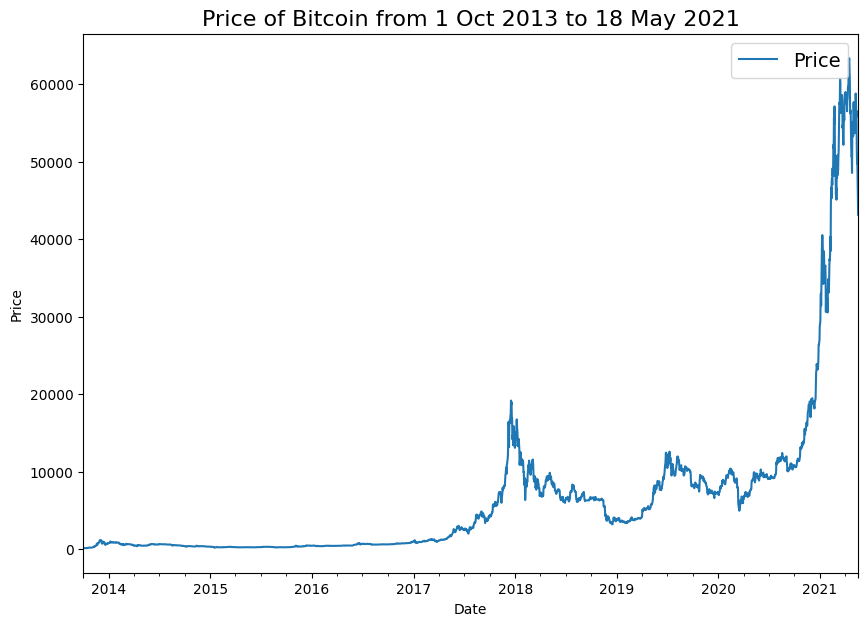

In [6]:
import matplotlib.pyplot as plt
daily_price_df.plot(figsize=(10,7))
plt.ylabel("Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## 2. Creating the training and test set
### 2.1 The wrong way

In [7]:
# Convert our dataframe index and columns to numpy arrays
timesteps = daily_price_df.index.to_numpy()
prices = daily_price_df["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(timesteps
                                                   ,prices
                                                   ,test_size=0.2
                                                   ,random_state=42)
len(X_train),len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

### 2.2 Let's visualize the splits

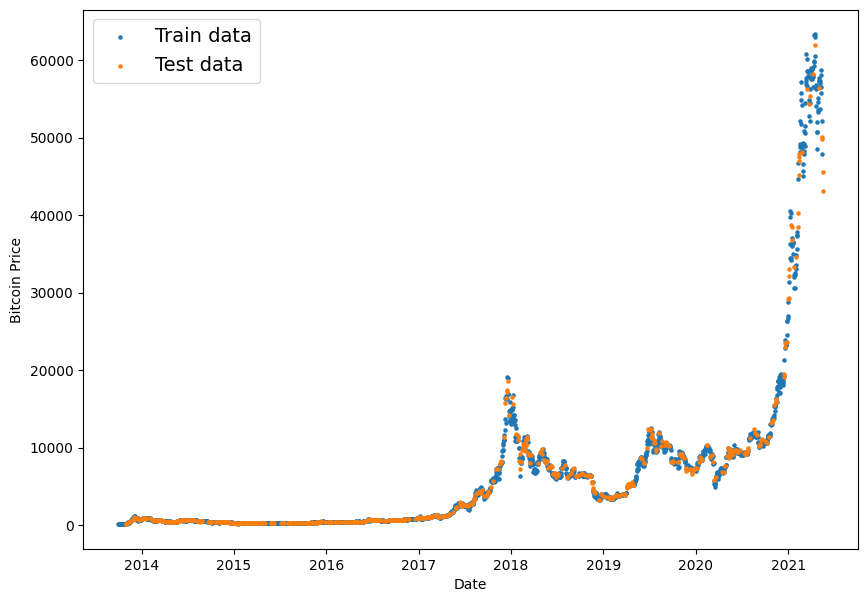

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=14)
plt.show();

As we can see in the above plot our test data is scattered across the training data. This kind of random split works great with data where there is no temporal (time) component. But when time component is invovled, we need to split the data in such a way that it should reflect our purpose. The purpose here is to analyze the historical price and predict or forecast the future price.

### 2.3 Creating the train test split the right way

In [10]:
split_size = int(0.8* len(prices))

X_train,y_train = timesteps[:split_size],prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

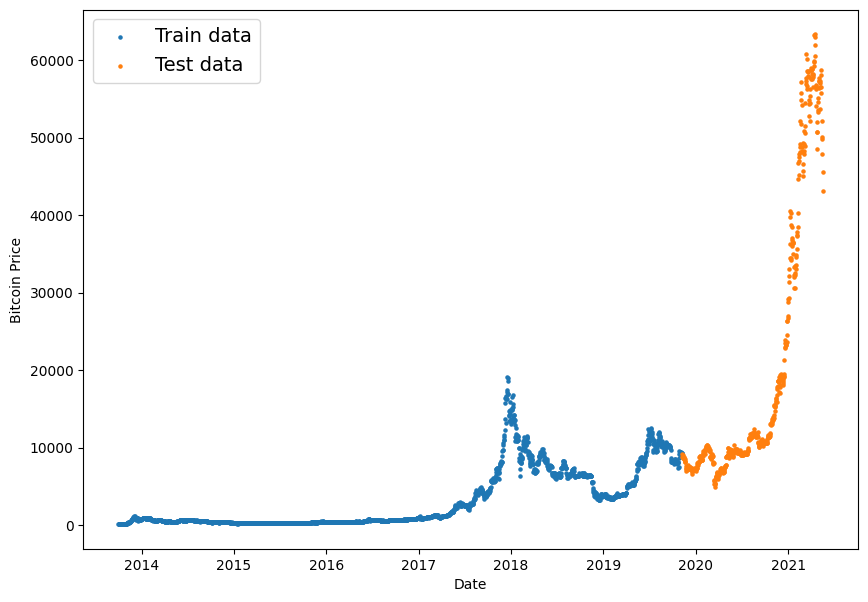

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=14)
plt.show();

## Model 0: Navive Forecast ( baseline )
As usual lets start with a baseline.
One of the most common baseline for time series forecasting, the naive model requires no training.
That's because all that the naive model does is forecast the next timestep value based on previous timestep value.
The formula looks like:

̂y<sub>t</sub> = y<sub>t</sub> -1

In [12]:
# create a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10],naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [13]:
# Create a plotting function

def plot_time_series(timesteps,values,format='.', start=0, end=None, label=None):
  """
    Plots a timesteps (a series of points in time) against values ( a series of values across timesteps)

    Parameters
    -------------
    timesteps: array of timesteps
    values: array of values across time
    format: style of plot, default "."
    start: where to start the plot ( setting a value will index from start of timesteps and values)
    end: where to end the plot (setting a value will index from end of timesteps & values )
    label: label to show on plot of values
  """
  ## Plot the series
  plt.plot(timesteps[start:end],values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

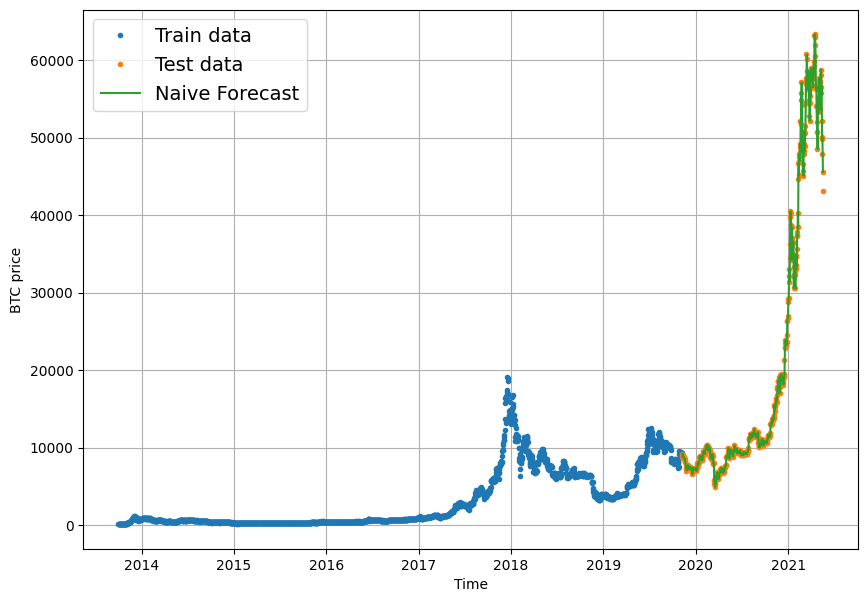

In [14]:
# Plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="Train data")
plot_time_series(timesteps=X_test,values=y_test,label="Test data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,format="-",label="Naive Forecast")

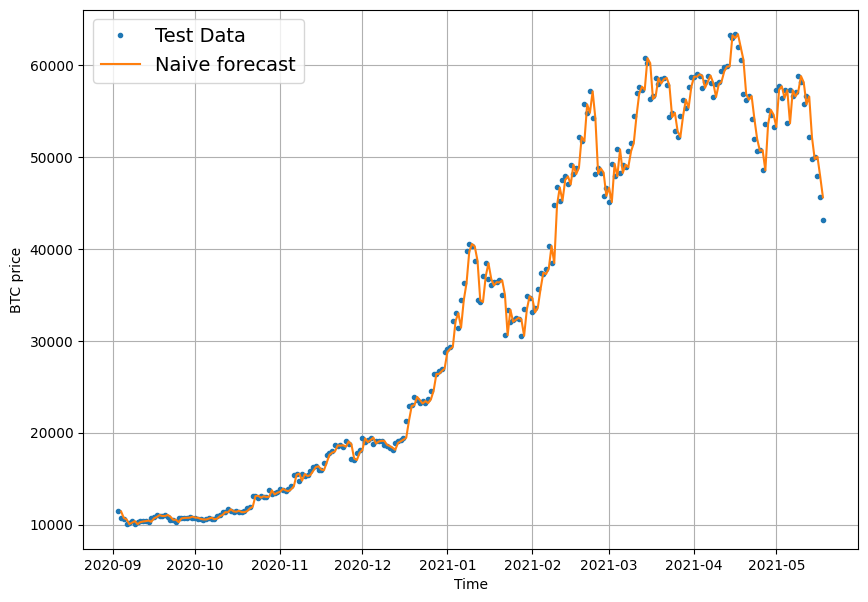

In [15]:
plt.figure(figsize=(10,7))
offset = 300
plot_time_series(timesteps=X_test,values=y_test, start=offset, label="Test Data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast, format="-", start=offset, label="Naive forecast")

## Evaluate a time series model
Time series forecasting often involves predicting a number.
As the problem statement is about predicting a number, it comes under **regression**
For all the following metrics **lower is better** ( for e.g MAE 0 is better than MAE 100)

### Scale-depdendent errors
These are metrics which can be used to compare time series values and forecast that are on the same scale

Metrics| Details|Code
---|---|---
MAE ( Mean Absolute Error ) | Easy to interpret. Forecast methods which minimizes the <br> MAE will lead to forecasts of the median |`tf.keras.metrics.mean_absolute_error()`
RMSE(Root Mean Squared Error ) | Forecast which minimizes the RMSE lead to forecasts <br> to the mean| `tf.keras.metrics.mean_squared_error()`

### Percentage Errors
Percentage errors do not have units, which mean they can be used to compare forecasts across different units.

Metrics|Details|Code
---|---|---
**MAPE**(Mean Absolute Percentage Error)|Most commonly used percentage error|`tf.keras.metrics.mean_absolute_percentage_error`
**sMAPE**(symmetric Mean Absolute Percentage Error)| Recommend not to use|Custom implementation

### Scaled Errors
Scaled errors are alternative to percentage errors when comparing forecasting performance across different timeseries

Metrics|Details|Code
---|---|---
MASE(mean absolute scaled error)|A forecast which performs better than naive should get <1 MASE|See sktimes<br> `mase_loss()`


In [16]:
import tensorflow as tf


In [17]:
# MASE implemented
def mean_absolute_scaled_error(y_true, y_pred):
  """
    Implement MASE ( assuming no seasonality data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  ## find MAE for naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1]))

  return mae/mae_naive_no_season

> In practice the naive model should achieve an MASE of 1 (or very close to 1). Any model worse than the naive forecast will achieve an MASE of > 1 and any model better than naive forecast will achieve and MASE of < 1

Let's put each of our different evaluation metrics together into a function

In [18]:
def evaluate_pred(y_true,y_pred):
  #Make sure float32 ( for metric calculation)
  y_true= tf.cast(y_true,dtype=tf.float32)
  y_pred= tf.cast(y_pred,dtype=tf.float32)

  # Calculate various metrics
  mae= tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse= tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse= tf.sqrt(mse)
  mape= tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase= mean_absolute_scaled_error(y_true,y_pred)

  return {
      "mae": mae.numpy()
      ,"mse": mse.numpy()
      ,"rmse": rmse.numpy()
      ,"mape": mape.numpy()
      ,"mase": mase.numpy()
  }

In [19]:
naive_results= evaluate_pred(y_true=y_test[1:]
                             ,y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Looking at the MAE results, we can infer that on an average the predicted bitcoin price is off from the actual price by about ~567 USD.

## Format Data Part2: Windowing dataset
**Windowing** is a method to turn a time series dataset to _supervised learning problem_.
In other words, we want to use windows of the past to predict the future.
For example, for a univariate time series, windowing for one week(`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)
[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]
```

Let's write a function that can take a univariate time series and turn into windows and horizon of specified sizes.

We'll start the default horizon size of 1 and window size of 7


In [20]:
HORIZON= 1 # predict 1 timestep at a time
WINDOW_SIZE= 7 #use a week worth of timesteps to predict the horizon

Now we will write a function that will take an array and return a window and horizon


In [21]:
# Create a function to create labelled window data
def get_labelled_windows(x,horizon=1):
  """
    Creates a label for window dataset
    E.g if horizon=1 (default)
    Input: [1,2,3,4,5,6] -> Output ([1,2,3,4,5],[6])
  """
  return (x[:,:-horizon],x[:, -horizon:])

In [22]:
# Test the window labelling function
test_window, test_label= get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0),horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


#### Make window for the entire timeseries
Let's write a function which:
1. Create a window step of specific window size, for example `[[0,1,2,3,4,5,6]]`
2. Uses [Numpy Indexing]() to create a 2D of multiple window steps, for example
```
[[0,1,2,3,4,5,6,7]
 [1,2,3,4,5,6,7,8]
 [2,3,4,5,6,7,8,9]]
```
3. Uses the 2D array of multiple window steps to index to a target series.
4. Uses the `get_labelled_window` function we created above to turn the window steps into windows with a specified horizon.

In [23]:
import numpy as np

In [24]:
# Create a function to view Numpy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
   Turns a 1D array into a 2D array of sequential windows of a given window size.
  """
  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step= np.expand_dims(np.arange(window_size+horizon),axis=0)
  # 2. Create a 2D array of multiple window steps
  window_indexes= window_step+ np.expand_dims(np.arange(len(x)- (window_size+horizon-1)),axis=0).T
  # 3. Index on the target array with 2D array of multiple window steps
  windowed_array= x[window_indexes]
  # 4. Get the labelled windows
  windows, labels= get_labelled_windows(windowed_array,horizon=horizon)
  return windows,labels

In [25]:
np.expand_dims(np.arange(7+1),0).T

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]])

In [26]:
full_windows, full_labels= make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [27]:
## view the first 3 windows/labels
for i in range(3):
  print(f" Window: {full_windows[i]}, Label: {full_labels[i]}")

 Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], Label: [123.033]
 Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ], Label: [124.049]
 Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ], Label: [125.96116]


We can use tensorflow inbuilt functions to achieve the same output. We need to use `tf.keras.preprocessing.timeseries_dataset_from_array()`

TODO: We will look into this later.

### Turning windows into training and test set
Let's write a function that takes a full set of windows and their labels and splits them into train & test splits.

In [28]:
# Make the train/test split
def make_train_test_split(windows,labels,test_split=0.2):
  """
    Splits matching pairs of windows and labels into train and test split.

  """
  split_size= int(len(windows) * (1-test_split))

  train_windows= windows[:split_size]
  train_labels= labels[:split_size]
  test_windows= windows[split_size:]
  test_labels= labels[split_size:]

  return train_windows, train_labels, test_windows,test_labels


In [29]:
train_windows, train_labels, test_windows,test_labels = make_train_test_split(full_windows,full_labels)
len(train_windows), len(test_windows),  len(train_labels),len(test_labels)


(2224, 556, 2224, 556)

In [30]:
train_windows[:5],train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Making a model checkpoint
The `ModelCheckpoint` callback will monitor our model performance during the training and saves the best model to the file system by setting `save_best_only=True`

In [31]:
import os
# create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name,save_path="model_experiment"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name)
                                            ,verbose=0
                                            ,save_best_only=True)

## Model 1: Dense Model ( window = 7, horizon = 1)
Time to build one of our models

`model_1` will have:
* A single dense layer with 128 hidden units and ReLU activation unit.
* An output layer with linear activation.
* Adam optimizer with MAE loss
* Batch size of 128
* 100 epochs

In [32]:
import tensorflow as tf
from tensorflow.keras import layers

## set seed
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    layers.Dense(128,activation=tf.keras.activations.relu)
    ,layers.Dense(HORIZON,activation=tf.keras.activations.linear)
],name="model_1_dense")

model_1.compile(loss=tf.keras.losses.mean_absolute_error
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"]
                )

history_1= model_1.fit(x=train_windows
                       ,y=train_labels
                       ,epochs=100
                       ,verbose=1
                       ,batch_size=128
                       ,validation_data=(test_windows,test_labels)
                       ,callbacks=[create_model_checkpoint(model_name=model_1.name)]
                       )



Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 1053.5701 - mae: 1053.5701  

18/18 [==============================] - 8s 113ms/step - loss: 956.8798 - mae: 956.8798 - val_loss: 2443.9729 - val_mae: 2443.9729
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 280.6667 - mae: 280.6667

18/18 [==============================] - 1s 57ms/step - loss: 277.3925 - mae: 277.3925 - val_loss: 1084.5026 - val_mae: 1084.5026
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 197.9566 - mae: 197.9566

18/18 [==============================] - 1s 62ms/step - loss: 194.5791 - mae: 194.5791 - val_loss: 1044.6194 - val_mae: 1044.6194
Epoch 4/100
10/18 [===============>..............] - ETA: 0s - loss: 201.7539 - mae: 201.7539

18/18 [==============================] - 1s 72ms/step - loss: 184.1097 - mae: 184.1097 - val_loss: 979.7216 - val_mae: 979.7216
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 177.9099 - mae: 177.9099

18/18 [==============================] - 1s 72ms/step - loss: 176.2240 - mae: 176.2240 - val_loss: 972.2133 - val_mae: 972.2131
Epoch 6/100
13/18 [====================>.........] - ETA: 0s - loss: 169.9920 - mae: 169.9920

18/18 [==============================] - 2s 124ms/step - loss: 173.3901 - mae: 173.3901 - val_loss: 943.2653 - val_mae: 943.2653
Epoch 7/100
18/18 [==============================] - 0s 14ms/step - loss: 167.6898 - mae: 167.6898 - val_loss: 947.1864 - val_mae: 947.1864
Epoch 8/100
11/18 [=================>............] - ETA: 0s - loss: 160.8317 - mae: 160.8317

18/18 [==============================] - 1s 85ms/step - loss: 162.1400 - mae: 162.1400 - val_loss: 884.5610 - val_mae: 884.5610
Epoch 9/100
13/18 [====================>.........] - ETA: 0s - loss: 158.3621 - mae: 158.3621

18/18 [==============================] - 1s 57ms/step - loss: 159.1862 - mae: 159.1862 - val_loss: 862.5930 - val_mae: 862.5930
Epoch 10/100
11/18 [=================>............] - ETA: 0s - loss: 149.7804 - mae: 149.7804

18/18 [==============================] - 2s 119ms/step - loss: 152.6482 - mae: 152.6482 - val_loss: 822.8583 - val_mae: 822.8583
Epoch 11/100
11/18 [=================>............] - ETA: 0s - loss: 151.6942 - mae: 151.6942

18/18 [==============================] - 1s 73ms/step - loss: 144.4857 - mae: 144.4857 - val_loss: 819.5328 - val_mae: 819.5328
Epoch 12/100
18/18 [==============================] - 0s 10ms/step - loss: 139.7048 - mae: 139.7048 - val_loss: 907.5400 - val_mae: 907.5400
Epoch 13/100
18/18 [==============================] - 0s 10ms/step - loss: 143.2242 - mae: 143.2242 - val_loss: 826.6231 - val_mae: 826.6231
Epoch 14/100
10/18 [===============>..............] - ETA: 0s - loss: 132.4082 - mae: 132.4082

18/18 [==============================] - 1s 54ms/step - loss: 133.8204 - mae: 133.8204 - val_loss: 800.5320 - val_mae: 800.5320
Epoch 15/100
10/18 [===============>..............] - ETA: 0s - loss: 134.4741 - mae: 134.4741

18/18 [==============================] - 1s 72ms/step - loss: 135.3541 - mae: 135.3541 - val_loss: 719.8356 - val_mae: 719.8356
Epoch 16/100
10/18 [===============>..............] - ETA: 0s - loss: 124.7608 - mae: 124.7608

18/18 [==============================] - 1s 58ms/step - loss: 128.0023 - mae: 128.0023 - val_loss: 719.2745 - val_mae: 719.2745
Epoch 17/100
18/18 [==============================] - 0s 10ms/step - loss: 125.9414 - mae: 125.9414 - val_loss: 756.5661 - val_mae: 756.5661
Epoch 18/100
11/18 [=================>............] - ETA: 0s - loss: 130.0704 - mae: 130.0704

18/18 [==============================] - 1s 65ms/step - loss: 125.1469 - mae: 125.1469 - val_loss: 675.2061 - val_mae: 675.2061
Epoch 19/100
18/18 [==============================] - 0s 8ms/step - loss: 123.7046 - mae: 123.7046 - val_loss: 708.9244 - val_mae: 708.9244
Epoch 20/100
14/18 [======================>.......] - ETA: 0s - loss: 123.1479 - mae: 123.1479

18/18 [==============================] - 1s 46ms/step - loss: 120.9481 - mae: 120.9481 - val_loss: 658.7219 - val_mae: 658.7219
Epoch 21/100
13/18 [====================>.........] - ETA: 0s - loss: 122.3717 - mae: 122.3717

18/18 [==============================] - 1s 47ms/step - loss: 123.8074 - mae: 123.8074 - val_loss: 652.0056 - val_mae: 652.0056
Epoch 22/100
18/18 [==============================] - 0s 8ms/step - loss: 125.2220 - mae: 125.2220 - val_loss: 657.5432 - val_mae: 657.5432
Epoch 23/100
14/18 [======================>.......] - ETA: 0s - loss: 122.9897 - mae: 122.9897

18/18 [==============================] - 1s 37ms/step - loss: 124.0158 - mae: 124.0158 - val_loss: 647.8320 - val_mae: 647.8320
Epoch 24/100
18/18 [==============================] - ETA: 0s - loss: 118.4333 - mae: 118.4333

18/18 [==============================] - 1s 34ms/step - loss: 118.4333 - mae: 118.4333 - val_loss: 637.2556 - val_mae: 637.2556
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 130.0738 - mae: 130.0738

18/18 [==============================] - 1s 30ms/step - loss: 118.7264 - mae: 118.7264 - val_loss: 632.2103 - val_mae: 632.2103
Epoch 26/100
15/18 [========================>.....] - ETA: 0s - loss: 121.8337 - mae: 121.8337

18/18 [==============================] - 1s 31ms/step - loss: 117.7322 - mae: 117.7322 - val_loss: 629.2712 - val_mae: 629.2712
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 167.9673 - mae: 167.9673

18/18 [==============================] - 1s 31ms/step - loss: 117.3067 - mae: 117.3067 - val_loss: 629.1772 - val_mae: 629.1772
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 103.9655 - mae: 103.9655

18/18 [==============================] - 1s 31ms/step - loss: 115.2397 - mae: 115.2397 - val_loss: 621.0964 - val_mae: 621.0964
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 112.8937 - mae: 112.8937

18/18 [==============================] - 1s 31ms/step - loss: 114.3455 - mae: 114.3455 - val_loss: 616.9827 - val_mae: 616.9827
Epoch 30/100
18/18 [==============================] - ETA: 0s - loss: 118.3726 - mae: 118.3726

18/18 [==============================] - 1s 46ms/step - loss: 118.3726 - mae: 118.3726 - val_loss: 615.3510 - val_mae: 615.3510
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 119.3612 - mae: 119.3612 - val_loss: 755.6614 - val_mae: 755.6614
Epoch 32/100
15/18 [========================>.....] - ETA: 0s - loss: 121.3470 - mae: 121.3470

18/18 [==============================] - 1s 30ms/step - loss: 120.8258 - mae: 120.8258 - val_loss: 609.8228 - val_mae: 609.8228
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 115.1846 - mae: 115.1846 - val_loss: 637.6974 - val_mae: 637.6974
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 113.7457 - mae: 113.7457 - val_loss: 627.1185 - val_mae: 627.1185
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 108.3373 - mae: 108.3373

18/18 [==============================] - 1s 30ms/step - loss: 112.6226 - mae: 112.6226 - val_loss: 602.2773 - val_mae: 602.2773
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 114.8820 - mae: 114.8820 - val_loss: 607.0629 - val_mae: 607.0629
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 112.1110 - mae: 112.1110 - val_loss: 607.9889 - val_mae: 607.9889
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 99.0814 - mae: 99.0814

18/18 [==============================] - 1s 30ms/step - loss: 112.1750 - mae: 112.1750 - val_loss: 597.1473 - val_mae: 597.1473
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 128.5988 - mae: 128.5988

18/18 [==============================] - 1s 32ms/step - loss: 110.6961 - mae: 110.6961 - val_loss: 593.4857 - val_mae: 593.4857
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 111.0818 - mae: 111.0818 - val_loss: 619.6993 - val_mae: 619.6993
Epoch 41/100
18/18 [==============================] - ETA: 0s - loss: 110.7675 - mae: 110.7675

18/18 [==============================] - 1s 30ms/step - loss: 110.7675 - mae: 110.7675 - val_loss: 591.5626 - val_mae: 591.5626
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 114.8517 - mae: 114.8517 - val_loss: 626.3323 - val_mae: 626.3323
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 115.3673 - mae: 115.3673 - val_loss: 671.3164 - val_mae: 671.3164
Epoch 44/100
18/18 [==============================] - 0s 4ms/step - loss: 121.6383 - mae: 121.6383 - val_loss: 645.1659 - val_mae: 645.1659
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 112.4033 - mae: 112.4033 - val_loss: 593.0815 - val_mae: 593.0815
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 81.3599 - mae: 81.3599

18/18 [==============================] - 1s 30ms/step - loss: 113.1348 - mae: 113.1348 - val_loss: 588.7743 - val_mae: 588.7743
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 116.0770 - mae: 116.0770 - val_loss: 706.7618 - val_mae: 706.7618
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 111.2049 - mae: 111.2049 - val_loss: 589.0878 - val_mae: 589.0878
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 110.8097 - mae: 110.8097 - val_loss: 620.8923 - val_mae: 620.8923
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 114.8306 - mae: 114.8306 - val_loss: 608.7415 - val_mae: 608.7415
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 89.5170 - mae: 89.5170

18/18 [==============================] - 1s 30ms/step - loss: 110.8683 - mae: 110.8683 - val_loss: 583.2147 - val_mae: 583.2147
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 110.1818 - mae: 110.1818 - val_loss: 583.3763 - val_mae: 583.3763
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 111.9308 - mae: 111.9308 - val_loss: 625.1618 - val_mae: 625.1618
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 104.0814 - mae: 104.0814

18/18 [==============================] - 1s 37ms/step - loss: 111.9927 - mae: 111.9927 - val_loss: 582.6743 - val_mae: 582.6743
Epoch 55/100
13/18 [====================>.........] - ETA: 0s - loss: 121.5650 - mae: 121.5650

18/18 [==============================] - 1s 45ms/step - loss: 114.8503 - mae: 114.8503 - val_loss: 581.1111 - val_mae: 581.1111
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 111.5083 - mae: 111.5083 - val_loss: 732.6911 - val_mae: 732.6911
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 125.9841 - mae: 125.9841 - val_loss: 679.0607 - val_mae: 679.0607
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 116.0038 - mae: 116.0038 - val_loss: 589.2910 - val_mae: 589.2910
Epoch 59/100
15/18 [========================>.....] - ETA: 0s - loss: 112.9024 - mae: 112.9024

18/18 [==============================] - 1s 47ms/step - loss: 111.2215 - mae: 111.2215 - val_loss: 579.4917 - val_mae: 579.4917
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 107.0233 - mae: 107.0233 - val_loss: 589.3253 - val_mae: 589.3253
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 107.7359 - mae: 107.7359 - val_loss: 582.8373 - val_mae: 582.8373
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 109.9283 - mae: 109.9283 - val_loss: 592.5186 - val_mae: 592.5186
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 109.4121 - mae: 109.4121 - val_loss: 603.9506 - val_mae: 603.9506
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 108.7109 - mae: 108.7109 - val_loss: 593.3557 - val_mae: 593.3557
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 132.2437 - mae: 132.2437

18/18 [==============================] - 1s 31ms/step - loss: 108.3496 - mae: 108.3496 - val_loss: 576.9759 - val_mae: 576.9759
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 108.5342 - mae: 108.5342 - val_loss: 582.5417 - val_mae: 582.5417
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 108.1910 - mae: 108.1910 - val_loss: 638.7376 - val_mae: 638.7376
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 117.9850 - mae: 117.9850 - val_loss: 775.3229 - val_mae: 775.3229
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 131.8470 - mae: 131.8470 - val_loss: 682.8774 - val_mae: 682.8774
Epoch 70/100
 1/18 [>.............................] - ETA: 0s - loss: 129.8651 - mae: 129.8651

18/18 [==============================] - 1s 31ms/step - loss: 120.6489 - mae: 120.6489 - val_loss: 576.4322 - val_mae: 576.4322
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5906 - mae: 110.5906 - val_loss: 589.5642 - val_mae: 589.5642
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 100.3386 - mae: 100.3386

18/18 [==============================] - 1s 31ms/step - loss: 108.3554 - mae: 108.3554 - val_loss: 574.9540 - val_mae: 574.9540
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 112.0718 - mae: 112.0718 - val_loss: 629.7781 - val_mae: 629.7781
Epoch 74/100
17/18 [===========================>..] - ETA: 0s - loss: 106.5795 - mae: 106.5795

18/18 [==============================] - 1s 31ms/step - loss: 106.8026 - mae: 106.8026 - val_loss: 574.8398 - val_mae: 574.8398
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 108.3270 - mae: 108.3270 - val_loss: 585.0615 - val_mae: 585.0615
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 109.5804 - mae: 109.5804 - val_loss: 579.4362 - val_mae: 579.4362
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 109.2235 - mae: 109.2235 - val_loss: 578.8015 - val_mae: 578.8015
Epoch 78/100
 1/18 [>.............................] - ETA: 0s - loss: 109.0886 - mae: 109.0886

18/18 [==============================] - 1s 30ms/step - loss: 110.3685 - mae: 110.3685 - val_loss: 573.3442 - val_mae: 573.3442
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 108.3484 - mae: 108.3484 - val_loss: 581.5942 - val_mae: 581.5942
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 106.9604 - mae: 106.9604 - val_loss: 584.8035 - val_mae: 584.8035
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 95.3944 - mae: 95.3944

18/18 [==============================] - 1s 45ms/step - loss: 106.7186 - mae: 106.7186 - val_loss: 571.9850 - val_mae: 571.9850
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 189.3872 - mae: 189.3872

18/18 [==============================] - 1s 30ms/step - loss: 115.2316 - mae: 115.2316 - val_loss: 571.7502 - val_mae: 571.7502
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3825 - mae: 112.3825 - val_loss: 676.4044 - val_mae: 676.4044
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3456 - mae: 112.3456 - val_loss: 592.2118 - val_mae: 592.2118
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3527 - mae: 108.3527 - val_loss: 578.7579 - val_mae: 578.7579
Epoch 86/100
 1/18 [>.............................] - ETA: 0s - loss: 108.8644 - mae: 108.8644

18/18 [==============================] - 1s 29ms/step - loss: 106.2319 - mae: 106.2319 - val_loss: 571.6296 - val_mae: 571.6296
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 105.3663 - mae: 105.3663 - val_loss: 593.6370 - val_mae: 593.6370
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 107.0778 - mae: 107.0778 - val_loss: 592.8685 - val_mae: 592.8685
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 106.7410 - mae: 106.7410 - val_loss: 596.2823 - val_mae: 596.2823
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 109.1135 - mae: 109.1135 - val_loss: 607.1111 - val_mae: 607.1111
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 114.8328 - mae: 114.8328 - val_loss: 606.5919 - val_mae: 606.5919
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 107.5463 - mae: 107.5463 - val_loss: 593.8044 - val_mae: 593.8044
Epoch 93/100
18/18 [============

18/18 [==============================] - 1s 29ms/step - loss: 106.1351 - mae: 106.1351 - val_loss: 570.0320 - val_mae: 570.0320
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 106.6666 - mae: 106.6666 - val_loss: 582.8934 - val_mae: 582.8934
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 106.1490 - mae: 106.1490 - val_loss: 605.8773 - val_mae: 605.8773
Epoch 98/100
18/18 [==============================] - 0s 4ms/step - loss: 108.0426 - mae: 108.0426 - val_loss: 578.2303 - val_mae: 578.2303
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 107.7818 - mae: 107.7818 - val_loss: 576.4758 - val_mae: 576.4758
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 110.3427 - mae: 110.3427 - val_loss: 621.1770 - val_mae: 621.1770


In [33]:
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 621.1771 - mae: 621.1771


[621.1770629882812, 621.1770629882812]

In [34]:
# Load in best saved model and evaluate on test data
saved_model_1 = tf.keras.models.load_model("model_experiment/model_1_dense")
saved_model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 570.0320 - mae: 570.0320


[570.0320434570312, 570.0320434570312]

## Making forecast with a model ( on test dataset )
Since we are going to run more modelling experiments, lets write a function which can return the predictions given a model and input data

* Take a trained model
* Take in some input data
* Pass the input data to the model
* Returns the prediction

In [35]:
def make_preds(model,input_data):
  """
    Uses model to make predictions on input data

    Args:
      model: trained model
      input_data: windowed input data ( same kind as the model is trained on)
    Returns:
      model prediction on input data
  """
  return tf.squeeze(model.predict(input_data))

In [36]:
model_1_preds = make_preds(model_1,test_windows)
model_1_preds[:10], len(model_1_preds)

18/18 [==============================] - 0s 1ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8745.178, 8659.776, 8933.941, 8668.886, 8620.246, 8664.341,
        8571.912, 8399.039, 8373.281, 8419.855], dtype=float32)>,
 556)

### Now lets evaluate our model using the `evaluate_model` method we create above in this notebook

In [37]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [38]:
evaluate_pred?

In [39]:
model_1_results = evaluate_pred(y_true=tf.squeeze(test_labels)
                                ,y_pred=model_1_preds)
model_1_results

{'mae': 621.17706,
 'mse': 1265186.8,
 'rmse': 1124.8052,
 'mape': 2.8067942,
 'mase': 1.091236}

### Let us use the `plot_time_series` function to plot the `model_1_preds` against the test_data

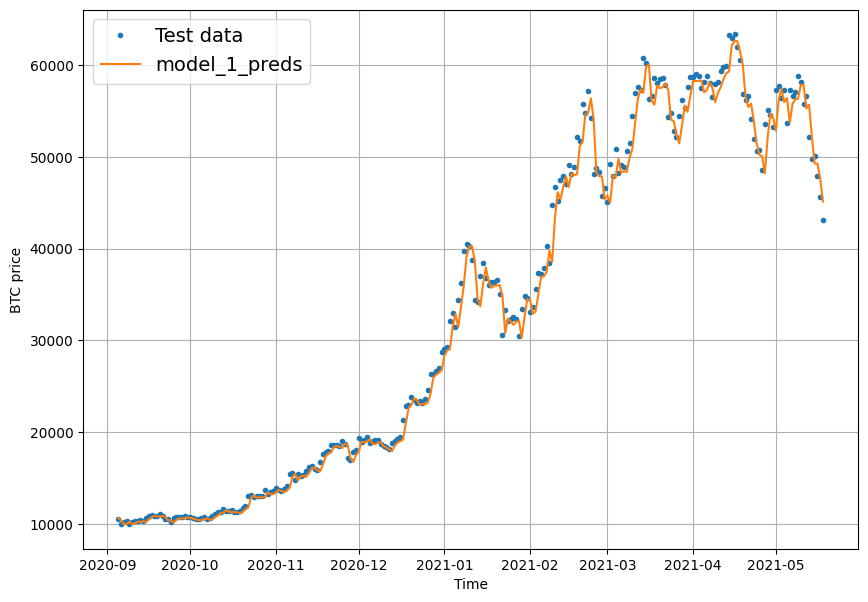

In [40]:
offset= 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0]
                 ,start=offset,label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_1_preds
                 ,start=offset,label="model_1_preds",format="-")


## Model 2: Window size=30, Horizon=1
We will start with our second modelling experiment where the window size=30 and horizon=1

We will use the functions we have created earlier to create our train/test feature and train/test labels


In [41]:
HORIZON=1
WINDOW_SIZE=30

In [42]:
full_windows, full_labels = make_windows(prices,window_size=WINDOW_SIZE
                                         ,horizon=HORIZON)

len(full_windows), len(full_labels)

(2757, 2757)

In [43]:
train_window, train_label, test_window , test_label=make_train_test_split(full_windows
                                                                         ,full_labels
                                                                         ,test_split=0.2)
len(train_window), len(train_label), len(test_window), len(test_label)


(2205, 2205, 552, 552)

In [44]:
import tensorflow as tf
from tensorflow.keras import layers

# set seed
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128,activation="relu")
    ,layers.Dense(HORIZON,activation="linear")
],name="model_2_Dense")

model_2.compile(loss="mae"
                 ,optimizer=tf.keras.optimizers.Adam()
                 ,metrics=["mae"]
                 )
history_2 = model_2.fit(x=train_window
                        ,y=train_label
                        ,epochs=100
                        ,verbose=1
                        ,validation_data=(test_window,test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_2.name)])





Epoch 1/100
62/69 [=========================>....] - ETA: 0s - loss: 587.0901 - mae: 587.0901

69/69 [==============================] - 2s 18ms/step - loss: 553.7517 - mae: 553.7517 - val_loss: 1333.4984 - val_mae: 1333.4984
Epoch 2/100
65/69 [===========================>..] - ETA: 0s - loss: 227.2633 - mae: 227.2633

69/69 [==============================] - 1s 15ms/step - loss: 227.0511 - mae: 227.0511 - val_loss: 1315.4137 - val_mae: 1315.4137
Epoch 3/100
57/69 [=======================>......] - ETA: 0s - loss: 199.7621 - mae: 199.7621

69/69 [==============================] - 1s 10ms/step - loss: 191.1706 - mae: 191.1706 - val_loss: 928.2223 - val_mae: 928.2223
Epoch 4/100
69/69 [==============================] - 0s 4ms/step - loss: 180.6573 - mae: 180.6573 - val_loss: 1249.6102 - val_mae: 1249.6102
Epoch 5/100
56/69 [=======================>......] - ETA: 0s - loss: 183.5443 - mae: 183.5443

69/69 [==============================] - 1s 10ms/step - loss: 179.8211 - mae: 179.8211 - val_loss: 831.2066 - val_mae: 831.2066
Epoch 6/100
69/69 [==============================] - 0s 4ms/step - loss: 164.1174 - mae: 164.1174 - val_loss: 865.8315 - val_mae: 865.8315
Epoch 7/100
54/69 [======================>.......] - ETA: 0s - loss: 159.1322 - mae: 159.1322

69/69 [==============================] - 1s 11ms/step - loss: 159.2634 - mae: 159.2634 - val_loss: 825.4354 - val_mae: 825.4354
Epoch 8/100
69/69 [==============================] - 0s 4ms/step - loss: 168.2289 - mae: 168.2289 - val_loss: 1064.3855 - val_mae: 1064.3855
Epoch 9/100
69/69 [==============================] - 0s 4ms/step - loss: 198.5972 - mae: 198.5972 - val_loss: 831.4684 - val_mae: 831.4684
Epoch 10/100
58/69 [========================>.....] - ETA: 0s - loss: 149.3449 - mae: 149.3449

69/69 [==============================] - 1s 10ms/step - loss: 154.6322 - mae: 154.6322 - val_loss: 764.9357 - val_mae: 764.9357
Epoch 11/100
69/69 [==============================] - 0s 4ms/step - loss: 176.9118 - mae: 176.9118 - val_loss: 1088.3271 - val_mae: 1088.3271
Epoch 12/100
69/69 [==============================] - 0s 4ms/step - loss: 158.7527 - mae: 158.7527 - val_loss: 1019.3981 - val_mae: 1019.3981
Epoch 13/100
58/69 [========================>.....] - ETA: 0s - loss: 152.4295 - mae: 152.4295

69/69 [==============================] - 1s 11ms/step - loss: 158.2274 - mae: 158.2274 - val_loss: 728.1309 - val_mae: 728.1309
Epoch 14/100
69/69 [==============================] - 0s 3ms/step - loss: 183.0029 - mae: 183.0029 - val_loss: 1023.6817 - val_mae: 1023.6817
Epoch 15/100
54/69 [======================>.......] - ETA: 0s - loss: 196.5656 - mae: 196.5656

69/69 [==============================] - 1s 14ms/step - loss: 197.1502 - mae: 197.1502 - val_loss: 692.3262 - val_mae: 692.3262
Epoch 16/100
69/69 [==============================] - 0s 4ms/step - loss: 142.0767 - mae: 142.0767 - val_loss: 796.9110 - val_mae: 796.9110
Epoch 17/100
69/69 [==============================] - 0s 4ms/step - loss: 136.1264 - mae: 136.1264 - val_loss: 720.4853 - val_mae: 720.4853
Epoch 18/100
56/69 [=======================>......] - ETA: 0s - loss: 138.8038 - mae: 138.8038

69/69 [==============================] - 1s 10ms/step - loss: 142.1106 - mae: 142.1106 - val_loss: 679.4230 - val_mae: 679.4230
Epoch 19/100
69/69 [==============================] - 0s 4ms/step - loss: 141.7880 - mae: 141.7880 - val_loss: 889.8149 - val_mae: 889.8149
Epoch 20/100
69/69 [==============================] - 0s 4ms/step - loss: 146.6893 - mae: 146.6893 - val_loss: 870.5270 - val_mae: 870.5270
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 149.8558 - mae: 149.8558 - val_loss: 1336.3997 - val_mae: 1336.3997
Epoch 22/100
55/69 [======================>.......] - ETA: 0s - loss: 184.9824 - mae: 184.9824

69/69 [==============================] - 1s 11ms/step - loss: 174.3212 - mae: 174.3212 - val_loss: 659.0875 - val_mae: 659.0875
Epoch 23/100
69/69 [==============================] - 0s 4ms/step - loss: 156.1511 - mae: 156.1511 - val_loss: 990.2289 - val_mae: 990.2289
Epoch 24/100
69/69 [==============================] - 0s 4ms/step - loss: 138.9154 - mae: 138.9154 - val_loss: 788.0831 - val_mae: 788.0831
Epoch 25/100
62/69 [=========================>....] - ETA: 0s - loss: 136.3935 - mae: 136.3935

69/69 [==============================] - 1s 15ms/step - loss: 139.3307 - mae: 139.3307 - val_loss: 648.6149 - val_mae: 648.6149
Epoch 26/100
69/69 [==============================] - 0s 6ms/step - loss: 160.6401 - mae: 160.6401 - val_loss: 793.6105 - val_mae: 793.6105
Epoch 27/100
69/69 [==============================] - 0s 5ms/step - loss: 145.3609 - mae: 145.3609 - val_loss: 687.8707 - val_mae: 687.8707
Epoch 28/100
69/69 [==============================] - 1s 13ms/step - loss: 147.9901 - mae: 147.9901 - val_loss: 836.2113 - val_mae: 836.2113
Epoch 29/100
69/69 [==============================] - 1s 7ms/step - loss: 158.1319 - mae: 158.1319 - val_loss: 677.6315 - val_mae: 677.6315
Epoch 30/100
69/69 [==============================] - 0s 4ms/step - loss: 153.5619 - mae: 153.5619 - val_loss: 671.9083 - val_mae: 671.9083
Epoch 31/100
68/69 [============================>.] - ETA: 0s - loss: 147.3063 - mae: 147.3063

69/69 [==============================] - 1s 19ms/step - loss: 147.5229 - mae: 147.5229 - val_loss: 627.8545 - val_mae: 627.8545
Epoch 32/100
69/69 [==============================] - 0s 7ms/step - loss: 139.6677 - mae: 139.6677 - val_loss: 649.0336 - val_mae: 649.0336
Epoch 33/100
69/69 [==============================] - 1s 7ms/step - loss: 130.2829 - mae: 130.2829 - val_loss: 909.8125 - val_mae: 909.8125
Epoch 34/100
69/69 [==============================] - 0s 5ms/step - loss: 191.8789 - mae: 191.8789 - val_loss: 990.2371 - val_mae: 990.2371
Epoch 35/100
55/69 [======================>.......] - ETA: 0s - loss: 129.7623 - mae: 129.7623

69/69 [==============================] - 1s 11ms/step - loss: 130.1625 - mae: 130.1625 - val_loss: 619.1093 - val_mae: 619.1093
Epoch 36/100
58/69 [========================>.....] - ETA: 0s - loss: 133.5681 - mae: 133.5681

69/69 [==============================] - 1s 10ms/step - loss: 132.9977 - mae: 132.9977 - val_loss: 617.2054 - val_mae: 617.2054
Epoch 37/100
69/69 [==============================] - 0s 4ms/step - loss: 158.0366 - mae: 158.0366 - val_loss: 618.4286 - val_mae: 618.4286
Epoch 38/100
69/69 [==============================] - 0s 4ms/step - loss: 130.5579 - mae: 130.5579 - val_loss: 681.1780 - val_mae: 681.1780
Epoch 39/100
59/69 [========================>.....] - ETA: 0s - loss: 116.3363 - mae: 116.3363

69/69 [==============================] - 1s 10ms/step - loss: 121.5116 - mae: 121.5116 - val_loss: 609.4788 - val_mae: 609.4788
Epoch 40/100
69/69 [==============================] - 0s 3ms/step - loss: 129.6490 - mae: 129.6490 - val_loss: 1061.8804 - val_mae: 1061.8804
Epoch 41/100
69/69 [==============================] - 0s 4ms/step - loss: 149.2229 - mae: 149.2229 - val_loss: 1050.4261 - val_mae: 1050.4261
Epoch 42/100
69/69 [==============================] - 0s 4ms/step - loss: 132.3053 - mae: 132.3053 - val_loss: 612.7191 - val_mae: 612.7191
Epoch 43/100
69/69 [==============================] - 0s 4ms/step - loss: 144.6803 - mae: 144.6803 - val_loss: 622.6085 - val_mae: 622.6085
Epoch 44/100
69/69 [==============================] - 0s 4ms/step - loss: 133.2329 - mae: 133.2329 - val_loss: 611.3116 - val_mae: 611.3116
Epoch 45/100
69/69 [==============================] - 0s 4ms/step - loss: 145.4651 - mae: 145.4651 - val_loss: 630.2239 - val_mae: 630.2239
Epoch 46/100
69/69 [========

69/69 [==============================] - 1s 11ms/step - loss: 129.2612 - mae: 129.2612 - val_loss: 601.2531 - val_mae: 601.2531
Epoch 50/100
60/69 [=========================>....] - ETA: 0s - loss: 138.5108 - mae: 138.5108

69/69 [==============================] - 1s 10ms/step - loss: 137.6499 - mae: 137.6499 - val_loss: 595.1512 - val_mae: 595.1512
Epoch 51/100
54/69 [======================>.......] - ETA: 0s - loss: 122.4799 - mae: 122.4799

69/69 [==============================] - 1s 14ms/step - loss: 122.5240 - mae: 122.5240 - val_loss: 592.5122 - val_mae: 592.5122
Epoch 52/100
69/69 [==============================] - 0s 5ms/step - loss: 120.0209 - mae: 120.0209 - val_loss: 595.7538 - val_mae: 595.7538
Epoch 53/100
69/69 [==============================] - 0s 6ms/step - loss: 142.4950 - mae: 142.4950 - val_loss: 697.5176 - val_mae: 697.5176
Epoch 54/100
69/69 [==============================] - 0s 6ms/step - loss: 129.8174 - mae: 129.8174 - val_loss: 1032.6925 - val_mae: 1032.6925
Epoch 55/100
69/69 [==============================] - 0s 6ms/step - loss: 117.7286 - mae: 117.7286 - val_loss: 654.7116 - val_mae: 654.7116
Epoch 56/100
69/69 [==============================] - 0s 4ms/step - loss: 158.3032 - mae: 158.3032 - val_loss: 628.6641 - val_mae: 628.6641
Epoch 57/100
69/69 [==============================] - 0s 4ms/step - loss: 148.1432 - mae: 148.1432 - val_loss: 1049.5524 - val_mae: 1049.5524
Epoch 58/100
69/69 [========

69/69 [==============================] - 1s 10ms/step - loss: 143.0853 - mae: 143.0853 - val_loss: 585.1906 - val_mae: 585.1906
Epoch 79/100
69/69 [==============================] - 0s 4ms/step - loss: 129.5751 - mae: 129.5751 - val_loss: 639.6589 - val_mae: 639.6589
Epoch 80/100
69/69 [==============================] - 0s 4ms/step - loss: 122.7231 - mae: 122.7231 - val_loss: 688.3046 - val_mae: 688.3046
Epoch 81/100
69/69 [==============================] - 0s 4ms/step - loss: 133.0480 - mae: 133.0480 - val_loss: 633.4621 - val_mae: 633.4621
Epoch 82/100
69/69 [==============================] - 0s 4ms/step - loss: 124.9953 - mae: 124.9953 - val_loss: 595.9858 - val_mae: 595.9858
Epoch 83/100
69/69 [==============================] - 0s 4ms/step - loss: 113.0518 - mae: 113.0518 - val_loss: 655.1730 - val_mae: 655.1730
Epoch 84/100
69/69 [==============================] - 0s 4ms/step - loss: 131.9756 - mae: 131.9756 - val_loss: 846.9486 - val_mae: 846.9486
Epoch 85/100
69/69 [============

69/69 [==============================] - 1s 11ms/step - loss: 122.1006 - mae: 122.1006 - val_loss: 583.2401 - val_mae: 583.2401
Epoch 86/100
69/69 [==============================] - 0s 4ms/step - loss: 128.8363 - mae: 128.8363 - val_loss: 966.7707 - val_mae: 966.7707
Epoch 87/100
69/69 [==============================] - 0s 4ms/step - loss: 132.8108 - mae: 132.8108 - val_loss: 1095.8568 - val_mae: 1095.8568
Epoch 88/100
69/69 [==============================] - 0s 4ms/step - loss: 130.0081 - mae: 130.0081 - val_loss: 808.6107 - val_mae: 808.6107
Epoch 89/100
69/69 [==============================] - 0s 4ms/step - loss: 119.8899 - mae: 119.8899 - val_loss: 712.8712 - val_mae: 712.8712
Epoch 90/100
69/69 [==============================] - 0s 6ms/step - loss: 143.2226 - mae: 143.2226 - val_loss: 882.8193 - val_mae: 882.8193
Epoch 91/100
69/69 [==============================] - 0s 6ms/step - loss: 131.4568 - mae: 131.4568 - val_loss: 632.2177 - val_mae: 632.2177
Epoch 92/100
69/69 [==========

In [45]:
# Evaluate model
model_2.evaluate(test_window,test_label)

18/18 [==============================] - 0s 2ms/step - loss: 584.2114 - mae: 584.2114


[584.21142578125, 584.21142578125]

In [46]:
model_2_preds = make_preds(model_2,test_window)
len(model_2_preds),model_2_preds[:10]

18/18 [==============================] - 0s 2ms/step


(552,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8802.841 , 8794.443 , 8715.586 , 8537.484 , 8448.774 , 8423.33  ,
        8144.0728, 8130.2646, 8155.604 , 7680.9478], dtype=float32)>)

In [47]:
model_2_results = evaluate_pred(y_true=tf.squeeze(test_label)
                                ,y_pred=model_2_preds)
model_2_results

{'mae': 584.21136,
 'mse': 1196312.2,
 'rmse': 1093.7606,
 'mape': 2.6206105,
 'mase': 1.0212072}

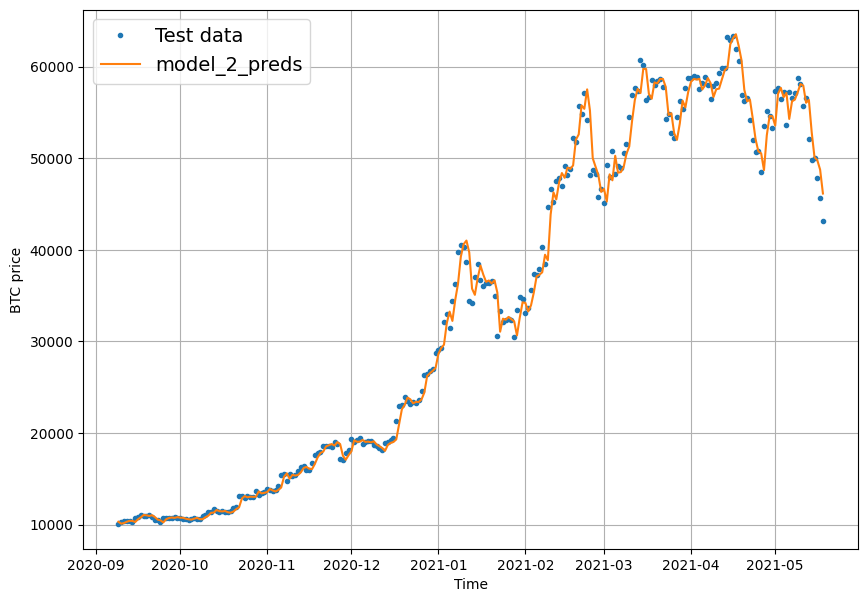

In [48]:
## Lets plot the predictions
offset=300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_window):],values=test_label[:,0]
                 ,start=offset,label="Test data")
plot_time_series(timesteps=X_test[-len(test_window):],values=model_2_preds
                 ,start=offset,label="model_2_preds",format="-")

## Model 3: Window size=30, Horizon=7

In [49]:
WINDOW_SIZE=30
HORIZON=7
full_window, full_label = make_windows(prices, window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_window), len(full_label)

(2751, 2751)

In [50]:
train_window, train_label, test_window, test_label = make_train_test_split(windows=full_window, labels=full_label
                                                                           ,test_split=0.2)
len(train_window), len(train_label), len(test_window), len(test_label)

(2200, 2200, 551, 551)

In [51]:
import tensorflow as tf
from tensorflow.keras import layers
# set random seed
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu")
    ,layers.Dense(HORIZON,activation="linear")
],name="model_3_dense")

model_3.compile(loss="mae"
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"])

history_3 = model_3.fit(x=train_window
                        ,y=train_label
                        ,epochs=100
                        ,verbose=1
                        ,validation_data=(test_window,test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
56/69 [=======================>......] - ETA: 0s - loss: 967.0258 - mae: 967.0258  

69/69 [==============================] - 2s 13ms/step - loss: 857.5723 - mae: 857.5723 - val_loss: 2108.6091 - val_mae: 2108.6091
Epoch 2/100
57/69 [=======================>......] - ETA: 0s - loss: 374.4214 - mae: 374.4214

69/69 [==============================] - 1s 15ms/step - loss: 382.3363 - mae: 382.3363 - val_loss: 1939.8473 - val_mae: 1939.8473
Epoch 3/100
63/69 [==========================>...] - ETA: 0s - loss: 331.6284 - mae: 331.6284

69/69 [==============================] - 1s 21ms/step - loss: 326.6486 - mae: 326.6486 - val_loss: 1748.6965 - val_mae: 1748.6965
Epoch 4/100
54/69 [======================>.......] - ETA: 0s - loss: 315.4007 - mae: 315.4007

69/69 [==============================] - 1s 11ms/step - loss: 309.0639 - mae: 309.0639 - val_loss: 1542.5647 - val_mae: 1542.5647
Epoch 5/100
69/69 [==============================] - 0s 4ms/step - loss: 296.2900 - mae: 296.2900 - val_loss: 1783.8656 - val_mae: 1783.8656
Epoch 6/100
69/69 [==============================] - 0s 4ms/step - loss: 283.8495 - mae: 283.8495 - val_loss: 1661.4321 - val_mae: 1661.4321
Epoch 7/100
55/69 [======================>.......] - ETA: 0s - loss: 295.8759 - mae: 295.8759

69/69 [==============================] - 1s 11ms/step - loss: 293.6825 - mae: 293.6825 - val_loss: 1520.5243 - val_mae: 1520.5243
Epoch 8/100
56/69 [=======================>......] - ETA: 0s - loss: 283.2675 - mae: 283.2675

69/69 [==============================] - 1s 11ms/step - loss: 279.4922 - mae: 279.4922 - val_loss: 1447.1348 - val_mae: 1447.1348
Epoch 9/100
69/69 [==============================] - 0s 4ms/step - loss: 269.7194 - mae: 269.7194 - val_loss: 1483.7446 - val_mae: 1483.7446
Epoch 10/100
56/69 [=======================>......] - ETA: 0s - loss: 276.7878 - mae: 276.7878

69/69 [==============================] - 1s 10ms/step - loss: 276.6572 - mae: 276.6572 - val_loss: 1427.3472 - val_mae: 1427.3472
Epoch 11/100
69/69 [==============================] - 0s 4ms/step - loss: 262.7866 - mae: 262.7866 - val_loss: 1457.8340 - val_mae: 1457.8340
Epoch 12/100
69/69 [==============================] - 0s 3ms/step - loss: 263.3871 - mae: 263.3871 - val_loss: 1534.5325 - val_mae: 1534.5325
Epoch 13/100
69/69 [==============================] - 0s 4ms/step - loss: 262.0811 - mae: 262.0811 - val_loss: 1693.6691 - val_mae: 1693.6691
Epoch 14/100
69/69 [==============================] - 0s 4ms/step - loss: 261.5452 - mae: 261.5452 - val_loss: 1476.8615 - val_mae: 1476.8615
Epoch 15/100
69/69 [==============================] - 0s 4ms/step - loss: 256.2701 - mae: 256.2701 - val_loss: 1574.2981 - val_mae: 1574.2981
Epoch 16/100
58/69 [========================>.....] - ETA: 0s - loss: 265.1870 - mae: 265.1870

69/69 [==============================] - 1s 10ms/step - loss: 262.4133 - mae: 262.4133 - val_loss: 1413.2871 - val_mae: 1413.2871
Epoch 17/100
69/69 [==============================] - 0s 4ms/step - loss: 254.6570 - mae: 254.6570 - val_loss: 1670.6650 - val_mae: 1670.6650
Epoch 18/100
59/69 [========================>.....] - ETA: 0s - loss: 253.3116 - mae: 253.3116

69/69 [==============================] - 1s 10ms/step - loss: 247.4242 - mae: 247.4242 - val_loss: 1337.2067 - val_mae: 1337.2067
Epoch 19/100
69/69 [==============================] - 0s 4ms/step - loss: 247.3042 - mae: 247.3042 - val_loss: 1476.0797 - val_mae: 1476.0797
Epoch 20/100
69/69 [==============================] - 0s 4ms/step - loss: 256.1658 - mae: 256.1658 - val_loss: 1396.6393 - val_mae: 1396.6393
Epoch 21/100
54/69 [======================>.......] - ETA: 0s - loss: 250.4118 - mae: 250.4118

69/69 [==============================] - 1s 10ms/step - loss: 247.3714 - mae: 247.3714 - val_loss: 1312.0004 - val_mae: 1312.0004
Epoch 22/100
69/69 [==============================] - 0s 4ms/step - loss: 244.4639 - mae: 244.4639 - val_loss: 1658.7184 - val_mae: 1658.7184
Epoch 23/100
69/69 [==============================] - 0s 4ms/step - loss: 242.0533 - mae: 242.0533 - val_loss: 1342.5502 - val_mae: 1342.5502
Epoch 24/100
69/69 [==============================] - 0s 3ms/step - loss: 246.4786 - mae: 246.4786 - val_loss: 1324.9462 - val_mae: 1324.9462
Epoch 25/100
69/69 [==============================] - 0s 4ms/step - loss: 242.1157 - mae: 242.1157 - val_loss: 1484.5374 - val_mae: 1484.5374
Epoch 26/100
69/69 [==============================] - 0s 4ms/step - loss: 240.4911 - mae: 240.4911 - val_loss: 1326.6835 - val_mae: 1326.6835
Epoch 27/100
69/69 [==============================] - 0s 4ms/step - loss: 243.4890 - mae: 243.4890 - val_loss: 1486.0229 - val_mae: 1486.0229
Epoch 28/100
69/69

69/69 [==============================] - 1s 15ms/step - loss: 237.0718 - mae: 237.0718 - val_loss: 1299.4396 - val_mae: 1299.4396
Epoch 34/100
69/69 [==============================] - 0s 4ms/step - loss: 234.3919 - mae: 234.3919 - val_loss: 1491.6716 - val_mae: 1491.6716
Epoch 35/100
54/69 [======================>.......] - ETA: 0s - loss: 241.5007 - mae: 241.5007

69/69 [==============================] - 1s 10ms/step - loss: 236.5428 - mae: 236.5428 - val_loss: 1258.7167 - val_mae: 1258.7167
Epoch 36/100
69/69 [==============================] - 0s 4ms/step - loss: 240.8566 - mae: 240.8566 - val_loss: 1342.8511 - val_mae: 1342.8511
Epoch 37/100
69/69 [==============================] - 0s 4ms/step - loss: 237.2099 - mae: 237.2099 - val_loss: 1296.3083 - val_mae: 1296.3083
Epoch 38/100
69/69 [==============================] - 0s 4ms/step - loss: 229.3691 - mae: 229.3691 - val_loss: 1378.1986 - val_mae: 1378.1986
Epoch 39/100
69/69 [==============================] - 0s 4ms/step - loss: 243.1673 - mae: 243.1673 - val_loss: 1343.3121 - val_mae: 1343.3121
Epoch 40/100
69/69 [==============================] - 0s 4ms/step - loss: 232.9174 - mae: 232.9174 - val_loss: 1376.6174 - val_mae: 1376.6174
Epoch 41/100
69/69 [==============================] - 0s 4ms/step - loss: 234.1609 - mae: 234.1609 - val_loss: 1304.7612 - val_mae: 1304.7612
Epoch 42/100
69/69

69/69 [==============================] - 1s 11ms/step - loss: 227.9220 - mae: 227.9220 - val_loss: 1248.7559 - val_mae: 1248.7559
Epoch 50/100
69/69 [==============================] - 0s 4ms/step - loss: 229.8847 - mae: 229.8847 - val_loss: 1378.8860 - val_mae: 1378.8860
Epoch 51/100
69/69 [==============================] - 0s 4ms/step - loss: 228.1684 - mae: 228.1684 - val_loss: 1474.6328 - val_mae: 1474.6328
Epoch 52/100
69/69 [==============================] - 0s 4ms/step - loss: 233.8458 - mae: 233.8458 - val_loss: 1252.2578 - val_mae: 1252.2578
Epoch 53/100
69/69 [==============================] - 0s 4ms/step - loss: 227.4236 - mae: 227.4236 - val_loss: 1263.7379 - val_mae: 1263.7379
Epoch 54/100
69/69 [==============================] - 0s 4ms/step - loss: 226.6062 - mae: 226.6062 - val_loss: 1386.4116 - val_mae: 1386.4116
Epoch 55/100
69/69 [==============================] - 0s 4ms/step - loss: 229.5290 - mae: 229.5290 - val_loss: 1333.3009 - val_mae: 1333.3009
Epoch 56/100
69/69

69/69 [==============================] - 1s 15ms/step - loss: 222.0749 - mae: 222.0749 - val_loss: 1246.3651 - val_mae: 1246.3651
Epoch 68/100
69/69 [==============================] - 0s 5ms/step - loss: 220.1191 - mae: 220.1191 - val_loss: 1322.6155 - val_mae: 1322.6155
Epoch 69/100
69/69 [==============================] - 0s 5ms/step - loss: 222.8182 - mae: 222.8182 - val_loss: 1641.6471 - val_mae: 1641.6471
Epoch 70/100
69/69 [==============================] - 0s 5ms/step - loss: 227.1975 - mae: 227.1975 - val_loss: 1409.0306 - val_mae: 1409.0306
Epoch 71/100
69/69 [==============================] - 0s 4ms/step - loss: 226.6450 - mae: 226.6450 - val_loss: 1427.9769 - val_mae: 1427.9769
Epoch 72/100
69/69 [==============================] - 0s 4ms/step - loss: 229.8160 - mae: 229.8160 - val_loss: 1304.5098 - val_mae: 1304.5098
Epoch 73/100
69/69 [==============================] - 0s 4ms/step - loss: 225.1710 - mae: 225.1710 - val_loss: 1312.1272 - val_mae: 1312.1272
Epoch 74/100
69/69

69/69 [==============================] - 1s 10ms/step - loss: 218.3621 - mae: 218.3621 - val_loss: 1219.9651 - val_mae: 1219.9651
Epoch 78/100
69/69 [==============================] - 0s 4ms/step - loss: 229.0802 - mae: 229.0802 - val_loss: 1275.5841 - val_mae: 1275.5841
Epoch 79/100
69/69 [==============================] - 0s 3ms/step - loss: 219.3634 - mae: 219.3634 - val_loss: 1277.0214 - val_mae: 1277.0214
Epoch 80/100
69/69 [==============================] - 0s 4ms/step - loss: 222.4312 - mae: 222.4312 - val_loss: 1255.9994 - val_mae: 1255.9994
Epoch 81/100
69/69 [==============================] - 0s 4ms/step - loss: 232.7625 - mae: 232.7625 - val_loss: 1291.8470 - val_mae: 1291.8470
Epoch 82/100
69/69 [==============================] - 0s 4ms/step - loss: 238.1424 - mae: 238.1424 - val_loss: 1649.8767 - val_mae: 1649.8767
Epoch 83/100
69/69 [==============================] - 0s 3ms/step - loss: 221.9989 - mae: 221.9989 - val_loss: 1378.1456 - val_mae: 1378.1456
Epoch 84/100
69/69

69/69 [==============================] - 1s 11ms/step - loss: 218.0645 - mae: 218.0645 - val_loss: 1210.8916 - val_mae: 1210.8916
Epoch 93/100
69/69 [==============================] - 0s 4ms/step - loss: 222.6764 - mae: 222.6764 - val_loss: 1760.4056 - val_mae: 1760.4056
Epoch 94/100
69/69 [==============================] - 0s 4ms/step - loss: 231.3611 - mae: 231.3611 - val_loss: 1543.8394 - val_mae: 1543.8394
Epoch 95/100
69/69 [==============================] - ETA: 0s - loss: 228.1689 - mae: 228.1689

69/69 [==============================] - 1s 11ms/step - loss: 228.1689 - mae: 228.1689 - val_loss: 1206.5286 - val_mae: 1206.5286
Epoch 96/100
69/69 [==============================] - 0s 4ms/step - loss: 212.2499 - mae: 212.2499 - val_loss: 1274.3849 - val_mae: 1274.3849
Epoch 97/100
69/69 [==============================] - 0s 4ms/step - loss: 213.2979 - mae: 213.2979 - val_loss: 1276.7179 - val_mae: 1276.7179
Epoch 98/100
69/69 [==============================] - 0s 4ms/step - loss: 218.9685 - mae: 218.9685 - val_loss: 1231.2185 - val_mae: 1231.2185
Epoch 99/100
69/69 [==============================] - 0s 4ms/step - loss: 214.8703 - mae: 214.8703 - val_loss: 1273.9579 - val_mae: 1273.9579
Epoch 100/100
69/69 [==============================] - 0s 4ms/step - loss: 222.9947 - mae: 222.9947 - val_loss: 1477.2666 - val_mae: 1477.2666


In [52]:
model_3.evaluate(test_window,test_label)

18/18 [==============================] - 0s 2ms/step - loss: 1477.2666 - mae: 1477.2666


[1477.2666015625, 1477.2666015625]

In [53]:
model_3_preds = make_preds(model_3,test_window)
len(model_3_preds), model_3_preds[:10]

18/18 [==============================] - 0s 1ms/step


(551,
 <tf.Tensor: shape=(10, 7), dtype=float32, numpy=
 array([[8920.359 , 8913.002 , 9078.397 , 8953.775 , 9052.506 , 9082.184 ,
         9057.6875],
        [8493.172 , 8456.143 , 8701.997 , 8575.294 , 8782.79  , 8698.423 ,
         8690.169 ],
        [8421.844 , 8387.229 , 8587.71  , 8489.651 , 8738.117 , 8443.865 ,
         8560.626 ],
        [8526.728 , 8612.7705, 8826.858 , 8643.9375, 8817.906 , 8525.684 ,
         8673.964 ],
        [8452.84  , 8567.981 , 8750.743 , 8526.842 , 8613.491 , 8440.64  ,
         8347.739 ],
        [8326.763 , 8540.005 , 8628.755 , 8437.935 , 8447.623 , 8180.9463,
         8144.8833],
        [8367.756 , 8455.269 , 8505.788 , 8407.304 , 8353.352 , 8081.2983,
         8020.012 ],
        [8273.076 , 8282.6045, 8277.144 , 8165.4116, 8124.189 , 8012.9604,
         7881.9727],
        [8090.2144, 7976.237 , 8155.13  , 7864.293 , 7983.8667, 7794.158 ,
         7672.8286],
        [7941.1343, 7879.987 , 7958.528 , 7829.8643, 8041.514 , 7765.032 ,
     

In [54]:
model_3_results = evaluate_pred(y_true=tf.squeeze(test_label),
                                y_pred=model_3_preds)
model_3_results

{'mae': array([ 215.8549  ,  198.47098 ,  235.14146 ,  133.37277 ,  141.77512 ,
         120.018974,  105.8171  ,  150.23283 ,  275.44775 ,  385.92368 ,
         485.3393  ,  538.1856  ,  575.36725 ,  535.89984 ,  200.29604 ,
         256.04037 ,  372.4025  ,  535.765   ,  544.8794  ,  558.14777 ,
         225.88707 ,  223.0325  ,  141.31668 ,  128.35428 ,  229.75754 ,
         201.5586  ,  277.97998 ,  398.6653  ,  232.72963 ,  131.86746 ,
         135.8877  ,  154.26848 ,  155.66344 ,  189.65988 ,  251.67424 ,
         252.845   ,  243.85379 ,  340.69733 ,  362.467   ,  510.39062 ,
         927.2     ,  368.7348  ,  323.29263 ,  405.524   ,  189.97697 ,
         231.68025 ,  268.08252 ,  328.02463 ,  279.62918 ,  353.9064  ,
         338.18073 ,  243.01842 ,  177.34291 ,  311.16107 ,  459.08914 ,
         667.3931  ,  894.9057  ,  862.65607 ,  812.1088  ,  922.111   ,
         707.7256  ,  447.7558  ,  453.36343 ,  768.0778  ,  733.0576  ,
         797.2314  ,  785.82623 ,  792.83966

### Make our evaluation function work for larger horizons
We need to update `evaluate_preds` function to work with multiple shapes of data

In [55]:
def evaluate_preds(y_true,y_pred):
  """
   Ensure float32 for metric calculation
  """
  y_true= tf.cast(y_true,dtype=tf.float32)
  y_pred= tf.cast(y_pred,dtype=tf.float32)

  # Calculate the various metrics
  mae= tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mape= tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mse= tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse= tf.sqrt(mse)
  mase= mean_absolute_scaled_error(y_true,y_pred)

  ## Account for different size of matrices (for longer horizons reduce to single number)
  if mae.ndim > 0:
    mae= tf.reduce_mean(mae)
    mape= tf.reduce_mean(mape)
    rmse= tf.reduce_mean(rmse)
    mase= tf.reduce_mean(mase)
    mse= tf.reduce_mean(mse)

  return {
       "mse":mse.numpy()
      ,"rmse":rmse.numpy()
      ,"mase":mase.numpy()
      ,"mape":mape.numpy()
      ,"mae":mae.numpy()
  }

In [56]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_label),
                                 y_pred=model_3_preds)
model_3_results

{'mse': 6380957.5,
 'rmse': 1643.7631,
 'mase': 2.6287131,
 'mape': 6.726566,
 'mae': 1477.2665}

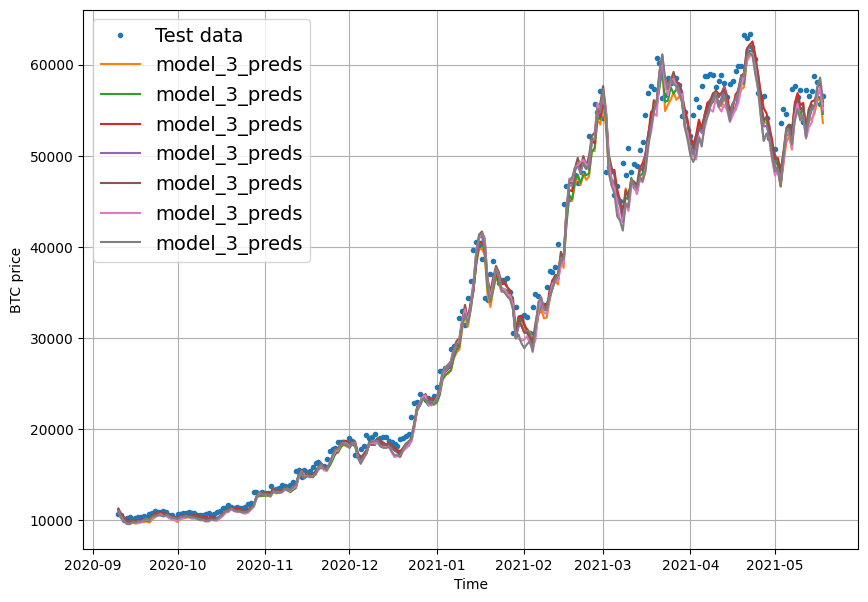

In [57]:
## Visualize the predictions
offset= 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps= X_test[-len(test_window):]
                 ,values= test_label[:,0]
                 ,start= offset
                 ,label= "Test data")
plot_time_series(timesteps= X_test[-len(test_window):]
                 ,values= model_3_preds
                 ,start= offset
                 ,label= "model_3_preds"
                 ,format= "-")

We can aggregate the model prediction

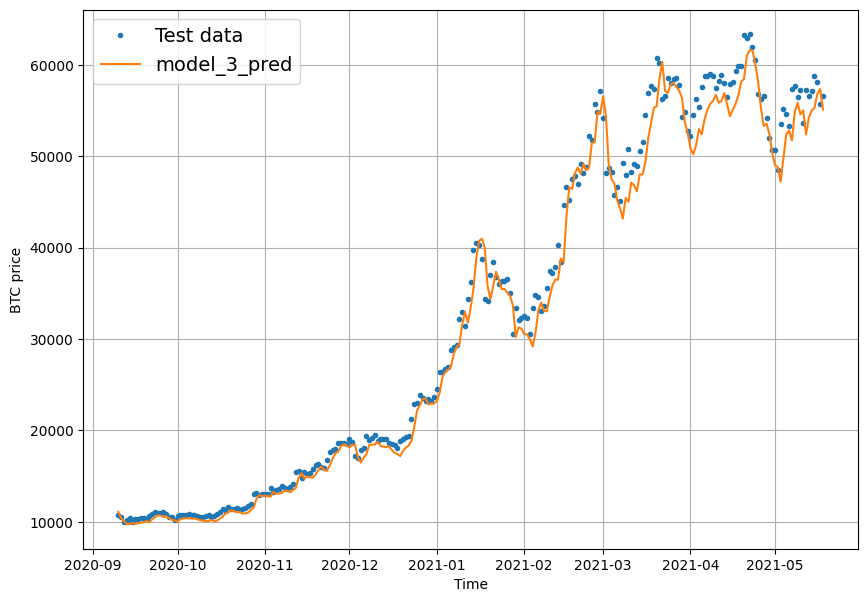

In [58]:
offset= 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_window):]
                 ,values=test_label[:,0]
                 ,start= offset
                 ,label= "Test data")
plot_time_series(timesteps=X_test[-len(test_window):]
                 ,values=tf.reduce_mean(model_3_preds,axis=1)
                 ,start= offset
                 ,label="model_3_pred"
                 ,format="-")

## Model 4: Conv1D
Our next modelling experiment.
This time we will use a Conv1D model. Conv1D can be used for a seq2seq (sequence to sequence) problems.

In our case, the input is the sequence of previous 7 days input and the output is price of bitcoin the following day. Since there are more than 1 input these kind of seq2seq problems are termed as many-to-one problem

In [59]:
HORIZON= 1
WINDOW_SIZE= 7


In [60]:
## Create windowed dataset
full_window,full_label= make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_window), len(full_label)

(2780, 2780)

In [61]:
## create train test split
train_window, train_label, test_window, test_label = make_train_test_split(windows=full_window
                                                                           ,labels=full_label
                                                                           ,test_split=0.2)
len(train_window), len(train_label), len(test_window), len(test_label)

(2224, 2224, 556, 556)

The Conv1D in Tensorflow takes an input of :(`batch_size, timesteps,input_dim`)
In our case, the `batch_size` (defaults = 32) is handled for us but we need to prepare other inputs.
* `timesteps= WINDOW_SIZE` - the timeestep is also
referred to as `features`. Our `features` are the previous `WINDOW_SIZE` of bitcoin prices.
* `input_dim=HORIZON` our model views `WINDOW_SIZE` worth of data to predict `HORIZON`

In [62]:
# Check the shape of data samples
train_window[0].shape

(7,)

In [63]:
x= tf.constant(train_window[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))
print(f" Original Shape : {x.shape}")
print(f" Expanded Shape: {expand_dims_layer(x).shape}")
print(f" Original values with expanded shape: \n {expand_dims_layer(x)}")
print(f" Type after expanded dim: {type(expand_dims_layer(x))}")

 Original Shape : (7,)
 Expanded Shape: (7, 1)
 Original values with expanded shape: 
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]
 Type after expanded dim: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [64]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,axis=1))
    ,layers.Conv1D(filters=128,kernel_size=5
                   ,padding="causal",activation="relu")
    ,layers.Dense(HORIZON,activation="linear")
],name="model_4_Conv1D")

model_4.compile(loss="mae"
                ,optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

history_4 = model_4.fit(x=train_window
                        ,y=train_label
                        ,epochs=100
                        ,batch_size=32
                        ,validation_data=(test_window,test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_4.name)])


Epoch 1/100
70/70 [==============================] - ETA: 0s - loss: 599.6074 - mae: 599.6074

70/70 [==============================] - 8s 25ms/step - loss: 599.6074 - mae: 599.6074 - val_loss: 1023.5767 - val_mae: 1023.5767
Epoch 2/100
60/70 [========================>.....] - ETA: 0s - loss: 182.5389 - mae: 182.5389

70/70 [==============================] - 1s 15ms/step - loss: 180.7025 - mae: 180.7025 - val_loss: 1011.1785 - val_mae: 1011.1785
Epoch 3/100
59/70 [========================>.....] - ETA: 0s - loss: 178.7674 - mae: 178.7674

70/70 [==============================] - 1s 14ms/step - loss: 175.3036 - mae: 175.3036 - val_loss: 937.1274 - val_mae: 937.1274
Epoch 4/100
61/70 [=========================>....] - ETA: 0s - loss: 160.0406 - mae: 160.0406

70/70 [==============================] - 1s 14ms/step - loss: 159.2033 - mae: 159.2033 - val_loss: 857.4662 - val_mae: 857.4662
Epoch 5/100
70/70 [==============================] - 0s 5ms/step - loss: 156.5602 - mae: 156.5602 - val_loss: 936.6416 - val_mae: 936.6416
Epoch 6/100
66/70 [===========================>..] - ETA: 0s - loss: 140.9616 - mae: 140.9616

70/70 [==============================] - 2s 22ms/step - loss: 142.8228 - mae: 142.8228 - val_loss: 778.9194 - val_mae: 778.9194
Epoch 7/100
70/70 [==============================] - 0s 7ms/step - loss: 140.2234 - mae: 140.2234 - val_loss: 837.7363 - val_mae: 837.7363
Epoch 8/100
61/70 [=========================>....] - ETA: 0s - loss: 143.1950 - mae: 143.1950

70/70 [==============================] - 1s 17ms/step - loss: 144.3437 - mae: 144.3437 - val_loss: 737.0024 - val_mae: 737.0024
Epoch 9/100
70/70 [==============================] - 0s 5ms/step - loss: 140.9240 - mae: 140.9240 - val_loss: 969.1269 - val_mae: 969.1269
Epoch 10/100
57/70 [=======================>......] - ETA: 0s - loss: 156.5729 - mae: 156.5729

70/70 [==============================] - 1s 15ms/step - loss: 153.3822 - mae: 153.3822 - val_loss: 682.0092 - val_mae: 682.0092
Epoch 11/100
70/70 [==============================] - 0s 5ms/step - loss: 126.7622 - mae: 126.7622 - val_loss: 817.8079 - val_mae: 817.8079
Epoch 12/100
61/70 [=========================>....] - ETA: 0s - loss: 135.9511 - mae: 135.9511

70/70 [==============================] - 1s 15ms/step - loss: 135.2512 - mae: 135.2512 - val_loss: 643.1777 - val_mae: 643.1777
Epoch 13/100
60/70 [========================>.....] - ETA: 0s - loss: 121.3274 - mae: 121.3274

70/70 [==============================] - 1s 14ms/step - loss: 120.8249 - mae: 120.8249 - val_loss: 638.2075 - val_mae: 638.2075
Epoch 14/100
70/70 [==============================] - 0s 4ms/step - loss: 127.9479 - mae: 127.9479 - val_loss: 936.9015 - val_mae: 936.9015
Epoch 15/100
63/70 [==========================>...] - ETA: 0s - loss: 123.9907 - mae: 123.9907

70/70 [==============================] - 1s 14ms/step - loss: 124.1691 - mae: 124.1691 - val_loss: 626.7588 - val_mae: 626.7588
Epoch 16/100
70/70 [==============================] - 0s 4ms/step - loss: 118.9347 - mae: 118.9347 - val_loss: 640.8093 - val_mae: 640.8093
Epoch 17/100
61/70 [=========================>....] - ETA: 0s - loss: 116.5879 - mae: 116.5879

70/70 [==============================] - 1s 13ms/step - loss: 119.5978 - mae: 119.5978 - val_loss: 609.2408 - val_mae: 609.2408
Epoch 18/100
70/70 [==============================] - 0s 5ms/step - loss: 127.1680 - mae: 127.1680 - val_loss: 647.4897 - val_mae: 647.4897
Epoch 19/100
70/70 [==============================] - 0s 5ms/step - loss: 120.7089 - mae: 120.7089 - val_loss: 621.9705 - val_mae: 621.9705
Epoch 20/100
70/70 [==============================] - 0s 5ms/step - loss: 115.5973 - mae: 115.5973 - val_loss: 774.8401 - val_mae: 774.8401
Epoch 21/100
70/70 [==============================] - 0s 5ms/step - loss: 125.2860 - mae: 125.2860 - val_loss: 625.8053 - val_mae: 625.8053
Epoch 22/100
70/70 [==============================] - 0s 5ms/step - loss: 123.2180 - mae: 123.2180 - val_loss: 617.9509 - val_mae: 617.9509
Epoch 23/100
70/70 [==============================] - 0s 5ms/step - loss: 128.0575 - mae: 128.0575 - val_loss: 781.2495 - val_mae: 781.2495
Epoch 24/100
56/70 [============

70/70 [==============================] - 2s 22ms/step - loss: 119.0519 - mae: 119.0519 - val_loss: 591.1678 - val_mae: 591.1678
Epoch 25/100
70/70 [==============================] - 0s 6ms/step - loss: 120.3586 - mae: 120.3586 - val_loss: 617.9001 - val_mae: 617.9001
Epoch 26/100
70/70 [==============================] - 0s 6ms/step - loss: 126.1152 - mae: 126.1152 - val_loss: 658.2175 - val_mae: 658.2175
Epoch 27/100
70/70 [==============================] - 0s 6ms/step - loss: 117.8369 - mae: 117.8369 - val_loss: 845.9691 - val_mae: 845.9691
Epoch 28/100
70/70 [==============================] - 1s 7ms/step - loss: 119.6939 - mae: 119.6939 - val_loss: 601.7840 - val_mae: 601.7840
Epoch 29/100
70/70 [==============================] - 0s 5ms/step - loss: 117.6556 - mae: 117.6556 - val_loss: 596.7119 - val_mae: 596.7119
Epoch 30/100
61/70 [=========================>....] - ETA: 0s - loss: 114.1152 - mae: 114.1152

70/70 [==============================] - 1s 14ms/step - loss: 114.4089 - mae: 114.4089 - val_loss: 584.7780 - val_mae: 584.7780
Epoch 31/100
70/70 [==============================] - 0s 5ms/step - loss: 115.2857 - mae: 115.2857 - val_loss: 701.0346 - val_mae: 701.0346
Epoch 32/100
70/70 [==============================] - 0s 5ms/step - loss: 119.4550 - mae: 119.4550 - val_loss: 614.8627 - val_mae: 614.8627
Epoch 33/100
70/70 [==============================] - 0s 5ms/step - loss: 116.7088 - mae: 116.7088 - val_loss: 702.6680 - val_mae: 702.6680
Epoch 34/100
70/70 [==============================] - 0s 5ms/step - loss: 118.9199 - mae: 118.9199 - val_loss: 606.3463 - val_mae: 606.3463
Epoch 35/100
64/70 [==========================>...] - ETA: 0s - loss: 111.1383 - mae: 111.1383

70/70 [==============================] - 1s 14ms/step - loss: 111.3019 - mae: 111.3019 - val_loss: 584.3144 - val_mae: 584.3144
Epoch 36/100
70/70 [==============================] - 0s 5ms/step - loss: 117.0304 - mae: 117.0304 - val_loss: 736.2906 - val_mae: 736.2906
Epoch 37/100
63/70 [==========================>...] - ETA: 0s - loss: 113.0326 - mae: 113.0326

70/70 [==============================] - 1s 14ms/step - loss: 112.5112 - mae: 112.5112 - val_loss: 572.7949 - val_mae: 572.7949
Epoch 38/100
70/70 [==============================] - 0s 5ms/step - loss: 129.6409 - mae: 129.6409 - val_loss: 933.3226 - val_mae: 933.3226
Epoch 39/100
70/70 [==============================] - 0s 4ms/step - loss: 116.4687 - mae: 116.4687 - val_loss: 894.0953 - val_mae: 894.0953
Epoch 40/100
70/70 [==============================] - 0s 4ms/step - loss: 129.0633 - mae: 129.0633 - val_loss: 578.4609 - val_mae: 578.4609
Epoch 41/100
70/70 [==============================] - 0s 4ms/step - loss: 111.0567 - mae: 111.0567 - val_loss: 767.6026 - val_mae: 767.6026
Epoch 42/100
62/70 [=========================>....] - ETA: 0s - loss: 113.7279 - mae: 113.7279

70/70 [==============================] - 1s 14ms/step - loss: 114.4320 - mae: 114.4320 - val_loss: 570.7670 - val_mae: 570.7670
Epoch 43/100
70/70 [==============================] - 0s 5ms/step - loss: 113.2497 - mae: 113.2497 - val_loss: 585.2770 - val_mae: 585.2770
Epoch 44/100
70/70 [==============================] - 0s 5ms/step - loss: 113.6024 - mae: 113.6024 - val_loss: 582.8346 - val_mae: 582.8346
Epoch 45/100
70/70 [==============================] - 0s 5ms/step - loss: 111.5501 - mae: 111.5501 - val_loss: 587.0872 - val_mae: 587.0872
Epoch 46/100
70/70 [==============================] - 0s 4ms/step - loss: 125.2014 - mae: 125.2014 - val_loss: 611.4719 - val_mae: 611.4719
Epoch 47/100
70/70 [==============================] - 0s 4ms/step - loss: 111.1728 - mae: 111.1728 - val_loss: 787.2162 - val_mae: 787.2162
Epoch 48/100
70/70 [==============================] - 0s 4ms/step - loss: 123.5652 - mae: 123.5652 - val_loss: 631.2749 - val_mae: 631.2749
Epoch 49/100
70/70 [============

70/70 [==============================] - 1s 14ms/step - loss: 110.8205 - mae: 110.8205 - val_loss: 566.3448 - val_mae: 566.3448
Epoch 61/100
70/70 [==============================] - 0s 4ms/step - loss: 112.8550 - mae: 112.8550 - val_loss: 597.7111 - val_mae: 597.7111
Epoch 62/100
70/70 [==============================] - 0s 4ms/step - loss: 109.6082 - mae: 109.6082 - val_loss: 578.7551 - val_mae: 578.7551
Epoch 63/100
70/70 [==============================] - 0s 4ms/step - loss: 109.1213 - mae: 109.1213 - val_loss: 574.6755 - val_mae: 574.6755
Epoch 64/100
70/70 [==============================] - 0s 4ms/step - loss: 113.1390 - mae: 113.1390 - val_loss: 659.7540 - val_mae: 659.7540
Epoch 65/100
70/70 [==============================] - 0s 5ms/step - loss: 111.7835 - mae: 111.7835 - val_loss: 597.5804 - val_mae: 597.5804
Epoch 66/100
64/70 [==========================>...] - ETA: 0s - loss: 111.2255 - mae: 111.2255

70/70 [==============================] - 1s 14ms/step - loss: 110.1644 - mae: 110.1644 - val_loss: 566.1606 - val_mae: 566.1606
Epoch 67/100
70/70 [==============================] - 0s 4ms/step - loss: 109.0111 - mae: 109.0111 - val_loss: 627.2903 - val_mae: 627.2903
Epoch 68/100
70/70 [==============================] - 0s 5ms/step - loss: 107.9376 - mae: 107.9376 - val_loss: 572.7827 - val_mae: 572.7827
Epoch 69/100
70/70 [==============================] - 0s 4ms/step - loss: 112.2494 - mae: 112.2494 - val_loss: 646.7159 - val_mae: 646.7159
Epoch 70/100
70/70 [==============================] - 0s 4ms/step - loss: 112.3894 - mae: 112.3894 - val_loss: 576.9863 - val_mae: 576.9863
Epoch 71/100
70/70 [==============================] - 0s 5ms/step - loss: 108.5876 - mae: 108.5876 - val_loss: 605.0517 - val_mae: 605.0517
Epoch 72/100
70/70 [==============================] - 0s 4ms/step - loss: 110.8387 - mae: 110.8387 - val_loss: 661.3229 - val_mae: 661.3229
Epoch 73/100
70/70 [============

In [65]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Load the best model
saved_conv1d_model = tf.keras.models.load_model("/content/model_experiment/model_4_Conv1D")
saved_conv1d_model.evaluate(test_window,test_label)

18/18 [==============================] - 0s 3ms/step - loss: 566.1606 - mae: 566.1606


[566.1605834960938, 566.1605834960938]

In [67]:
model_4_preds = make_preds(saved_conv1d_model,test_window)
model_4_preds[:10],len(model_4_preds)

18/18 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8854.649, 8774.204, 9019.062, 8794.696, 8734.658, 8722.408,
        8678.326, 8522.817, 8452.356, 8515.371], dtype=float32)>,
 556)

In [68]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_label),
                                 y_pred=model_4_preds)
model_4_results

{'mse': 1163703.5,
 'rmse': 1078.7509,
 'mase': 0.9945874,
 'mape': 2.5267997,
 'mae': 566.16064}

## Model 5: RNN(LSTM)

In [69]:
import tensorflow as tf
from tensorflow.keras import layers

# set seed
tf.random.set_seed(42)

## Using the functional API
inputs= layers.Input(shape=(WINDOW_SIZE))
x= layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs)
x= layers.LSTM(128,activation="relu")(x)
outputs= layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs= inputs, outputs= outputs
                         ,name="model_5_LSTM")

model_5.compile(loss="mae"
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"])

history_5 = model_5.fit(x=train_window,
                        y=train_label
                        ,verbose=0
                        ,epochs=100
                        ,batch_size=32
                        ,validation_data=(test_window, test_label)
                        ,callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [70]:
# Load the best saved model
saved_lstm_model = tf.keras.models.load_model("/content/model_experiment/model_5_LSTM")
saved_lstm_model.evaluate(test_window,test_label)

18/18 [==============================] - 0s 2ms/step - loss: 561.3284 - mae: 561.3284


[561.3284301757812, 561.3284301757812]

In [71]:
model_5_preds= make_preds(saved_lstm_model,test_window)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8845.344, 8781.714, 9039.253, 8777.375, 8750.427, 8741.678,
       8672.627, 8533.349, 8457.847, 8531.522], dtype=float32)>

In [72]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_label),
                                 y_pred=model_5_preds)
model_5_results

{'mse': 1143795.6,
 'rmse': 1069.4838,
 'mase': 0.98609847,
 'mape': 2.5135489,
 'mae': 561.32837}

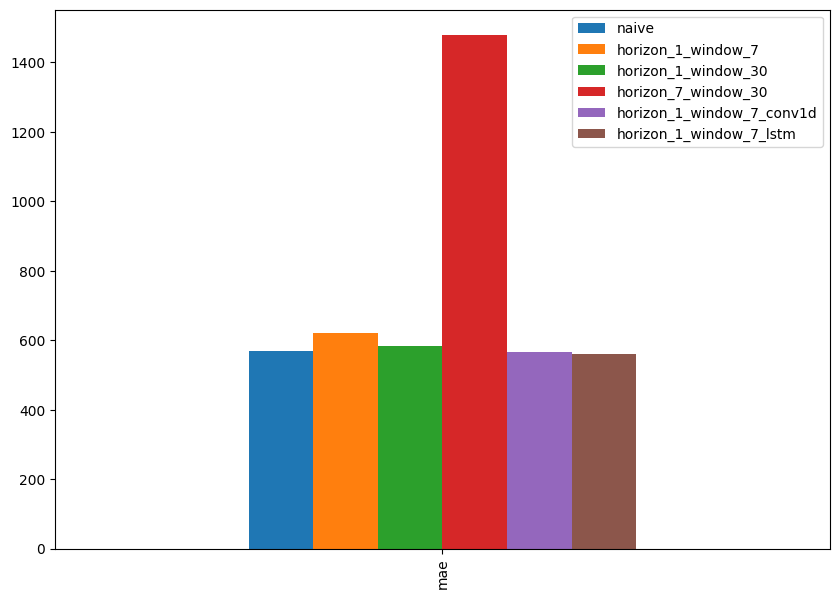

In [73]:
import pandas as pd
pd.DataFrame({
    "naive":naive_results["mae"]
    ,"horizon_1_window_7":model_1_results["mae"]
    ,"horizon_1_window_30":model_2_results["mae"]
    ,"horizon_7_window_30":model_3_results["mae"]
    ,"horizon_1_window_7_conv1d":model_4_results["mae"]
    ,"horizon_1_window_7_lstm":model_5_results["mae"]
},index=["mae"]).plot(figsize=(10,7),kind="bar");

## Make a Multivariate Time Series
Since we are dealing with Bitcoin prices, let's use the **Bitcoin Block Reward** as another bit of information that we can add to our timeseries dataset.

**Bitcoin Block Reward**: The number of blocks that someone receives by mining a Bitcoin Block.

The historical data shows, the number of blocks rewarded have halved every 4 years.

Block Reward|Start Date
---|---
50|03-January-2009(2009-01-03)
25|28-November-2012
12.5|9-July-2016
6.5|11-May-2020
3.125|TBA(Expected 2024)
1.5625|TBA(Expected 2028)


In [80]:
block_reward_1= 50
block_reward_2= 25
block_reward_3= 12.5
block_reward_4= 6.5

## Block Reward dates
block_reward_2_datetime=np.datetime64("2012-11-28")
block_reward_3_datetime=np.datetime64("2016-07-09")
block_reward_4_datetime=np.datetime64("2020-05-11")


From the above information, we should be able to get the block rewards applicable for each day in our dataset

In [81]:
# Get date indexes for when to add in a different block dates
block_reward_2_days= (block_reward_3_datetime-daily_price_df.index[0]).days
block_reward_3_days= (block_reward_4_datetime-daily_price_df.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

Now we can add another feature to our dataset `block_reward`

In [84]:
daily_prices_block = daily_price_df.copy()
daily_prices_block["block_reward"] = None

#Set values of block_reward column
daily_prices_block.iloc[:block_reward_2_days:,-1]= block_reward_2
daily_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1]= block_reward_3
daily_prices_block.iloc[block_reward_3_days:,-1]= block_reward_4

In [86]:
daily_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


import numpy as np
from google.colab import autoviz
df_4241545254247587310 = autoviz.get_df('df_4241545254247587310')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4241545254247587310, *['Price'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2296249444347363037 = autoviz.get_df('df_2296249444347363037')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_2296249444347363037, *['Price'], **{})
chart

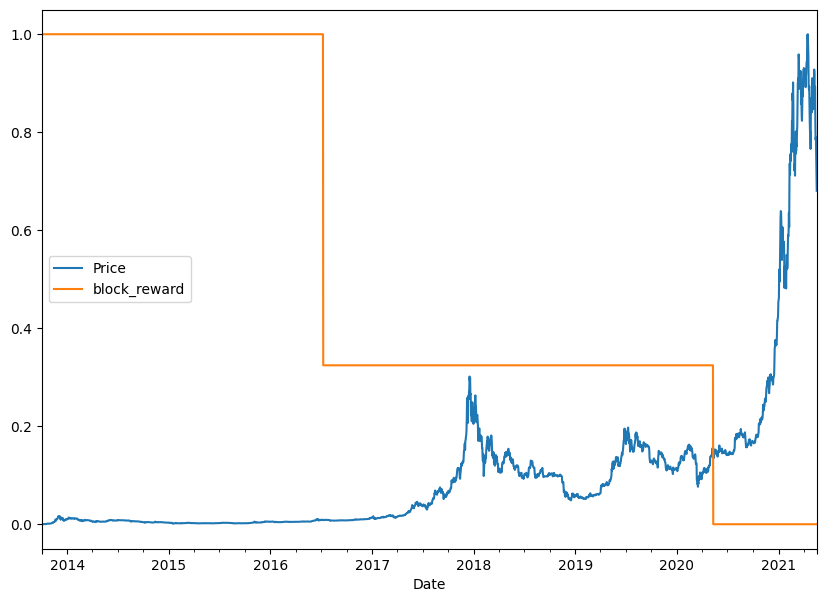

In [88]:
# Plot the block reward/price over time
from sklearn.preprocessing import minmax_scale
scaled_daily_price_block= pd.DataFrame(minmax_scale(daily_prices_block[["Price","block_reward"]])
                                       ,columns=daily_prices_block.columns
                                       ,index=daily_prices_block.index)
scaled_daily_price_block.plot(figsize=(10,7));

## Making a windowed dataset with pandas
Since, our data is in pandas dataframe, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** dataset

In [90]:
HORIZON= 1
WINDOW_SIZE= 7

bitcoin_price_windowed = daily_prices_block.copy()

# Add window columns
for i in range(WINDOW_SIZE):
  bitcoin_price_windowed[f"Price+{i+1}"]= bitcoin_price_windowed["Price"].shift(periods=i+1)

bitcoin_price_windowed.head(20)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


We will now remove the `NaN` values using pandas `dropna()` and create your feature and target columns


In [91]:
X = bitcoin_price_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y = bitcoin_price_windowed.dropna()["Price"].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [92]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [94]:
## Create the train and test dataset
split_size = int(0.8*len(X))
X_train,y_train = X[:split_size],y[:split_size]
X_test, y_test= X[split_size:],y[split_size:]
len(X_train),len(X_test),len(y_train),len(y_test)

(2224, 556, 2224, 556)

## Model 6: Dense ( Multivariate time series)

In [96]:
import tensorflow as tf
from tensorflow.keras import layers

# set random seed
tf.random.set_seed(42)

model_6= tf.keras.Sequential([
    layers.Dense(128,activation="relu")
    ,layers.Dense(HORIZON)
],name="model_6_multivariate_dense")

model_6.compile(loss="mae"
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["mae"])

history_6= model_6.fit(X_train
                       ,y_train
                       ,validation_data=(X_test,y_test)
                       ,epochs=100
                       ,batch_size=32
                       ,verbose=1
                       ,callbacks=[create_model_checkpoint(model_name=model_6.name)]
                      )


Epoch 1/100
69/70 [============================>.] - ETA: 0s - loss: 831.5640 - mae: 831.5640  

70/70 [==============================] - 2s 12ms/step - loss: 826.8651 - mae: 826.8651 - val_loss: 1245.6880 - val_mae: 1245.6880
Epoch 2/100
57/70 [=======================>......] - ETA: 0s - loss: 222.7548 - mae: 222.7548

70/70 [==============================] - 1s 10ms/step - loss: 218.7241 - mae: 218.7241 - val_loss: 1184.8689 - val_mae: 1184.8689
Epoch 3/100
57/70 [=======================>......] - ETA: 0s - loss: 202.0421 - mae: 202.0421

70/70 [==============================] - 1s 10ms/step - loss: 197.5379 - mae: 197.5379 - val_loss: 1046.7098 - val_mae: 1046.7098
Epoch 4/100
57/70 [=======================>......] - ETA: 0s - loss: 191.4938 - mae: 191.4938

70/70 [==============================] - 1s 10ms/step - loss: 183.9120 - mae: 183.9120 - val_loss: 937.9895 - val_mae: 937.9895
Epoch 5/100
55/70 [======================>.......] - ETA: 0s - loss: 169.2002 - mae: 169.2002

70/70 [==============================] - 1s 11ms/step - loss: 165.9600 - mae: 165.9600 - val_loss: 900.5990 - val_mae: 900.5990
Epoch 6/100
63/70 [==========================>...] - ETA: 0s - loss: 154.1786 - mae: 154.1786

70/70 [==============================] - 1s 15ms/step - loss: 155.2569 - mae: 155.2569 - val_loss: 808.9812 - val_mae: 808.9812
Epoch 7/100
70/70 [==============================] - 1s 9ms/step - loss: 151.2760 - mae: 151.2760 - val_loss: 821.4780 - val_mae: 821.4780
Epoch 8/100
60/70 [========================>.....] - ETA: 0s - loss: 144.1854 - mae: 144.1854

70/70 [==============================] - 1s 21ms/step - loss: 146.3981 - mae: 146.3981 - val_loss: 789.2631 - val_mae: 789.2631
Epoch 9/100
70/70 [==============================] - 0s 6ms/step - loss: 140.8216 - mae: 140.8216 - val_loss: 831.4006 - val_mae: 831.4006
Epoch 10/100
60/70 [========================>.....] - ETA: 0s - loss: 140.2242 - mae: 140.2242

70/70 [==============================] - 1s 17ms/step - loss: 144.3753 - mae: 144.3753 - val_loss: 696.7758 - val_mae: 696.7758
Epoch 11/100
70/70 [==============================] - 0s 7ms/step - loss: 130.3300 - mae: 130.3300 - val_loss: 862.1550 - val_mae: 862.1550
Epoch 12/100
70/70 [==============================] - 0s 5ms/step - loss: 133.5378 - mae: 133.5378 - val_loss: 871.1902 - val_mae: 871.1902
Epoch 13/100
67/70 [===========================>..] - ETA: 0s - loss: 132.3156 - mae: 132.3156

70/70 [==============================] - 1s 17ms/step - loss: 131.0980 - mae: 131.0980 - val_loss: 646.2304 - val_mae: 646.2304
Epoch 14/100
70/70 [==============================] - 0s 7ms/step - loss: 135.4066 - mae: 135.4066 - val_loss: 1127.6031 - val_mae: 1127.6031
Epoch 15/100
70/70 [==============================] - 0s 6ms/step - loss: 136.3095 - mae: 136.3095 - val_loss: 748.6383 - val_mae: 748.6383
Epoch 16/100
61/70 [=========================>....] - ETA: 0s - loss: 124.5650 - mae: 124.5650

70/70 [==============================] - 1s 18ms/step - loss: 124.3359 - mae: 124.3359 - val_loss: 629.2416 - val_mae: 629.2416
Epoch 17/100
66/70 [===========================>..] - ETA: 0s - loss: 119.9062 - mae: 119.9062

70/70 [==============================] - 1s 17ms/step - loss: 121.6303 - mae: 121.6303 - val_loss: 622.6379 - val_mae: 622.6379
Epoch 18/100
70/70 [==============================] - 0s 4ms/step - loss: 135.1293 - mae: 135.1293 - val_loss: 684.9450 - val_mae: 684.9450
Epoch 19/100
70/70 [==============================] - 0s 4ms/step - loss: 125.5032 - mae: 125.5032 - val_loss: 648.7350 - val_mae: 648.7350
Epoch 20/100
70/70 [==============================] - 0s 4ms/step - loss: 120.0815 - mae: 120.0815 - val_loss: 750.7620 - val_mae: 750.7620
Epoch 21/100
52/70 [=====================>........] - ETA: 0s - loss: 133.5500 - mae: 133.5500

70/70 [==============================] - 1s 10ms/step - loss: 131.3075 - mae: 131.3075 - val_loss: 613.0130 - val_mae: 613.0130
Epoch 22/100
70/70 [==============================] - 0s 4ms/step - loss: 124.0452 - mae: 124.0452 - val_loss: 651.5392 - val_mae: 651.5392
Epoch 23/100
67/70 [===========================>..] - ETA: 0s - loss: 121.4796 - mae: 121.4796

70/70 [==============================] - 2s 29ms/step - loss: 123.1240 - mae: 123.1240 - val_loss: 603.0161 - val_mae: 603.0161
Epoch 24/100
70/70 [==============================] - 1s 11ms/step - loss: 120.3678 - mae: 120.3678 - val_loss: 623.9554 - val_mae: 623.9554
Epoch 25/100
70/70 [==============================] - 1s 11ms/step - loss: 125.5571 - mae: 125.5571 - val_loss: 640.1877 - val_mae: 640.1877
Epoch 26/100
70/70 [==============================] - 0s 6ms/step - loss: 136.8268 - mae: 136.8268 - val_loss: 627.3268 - val_mae: 627.3268
Epoch 27/100
70/70 [==============================] - 0s 6ms/step - loss: 123.0973 - mae: 123.0973 - val_loss: 821.7790 - val_mae: 821.7790
Epoch 28/100
68/70 [============================>.] - ETA: 0s - loss: 124.1886 - mae: 124.1886

70/70 [==============================] - 2s 23ms/step - loss: 123.6881 - mae: 123.6881 - val_loss: 600.2876 - val_mae: 600.2876
Epoch 29/100
70/70 [==============================] - 1s 11ms/step - loss: 112.8762 - mae: 112.8762 - val_loss: 641.5769 - val_mae: 641.5769
Epoch 30/100
70/70 [==============================] - 1s 10ms/step - loss: 120.2539 - mae: 120.2539 - val_loss: 638.6950 - val_mae: 638.6950
Epoch 31/100
70/70 [==============================] - 1s 8ms/step - loss: 117.3644 - mae: 117.3644 - val_loss: 826.1132 - val_mae: 826.1132
Epoch 32/100
70/70 [==============================] - ETA: 0s - loss: 117.1361 - mae: 117.1361

70/70 [==============================] - 1s 16ms/step - loss: 117.1361 - mae: 117.1361 - val_loss: 597.7073 - val_mae: 597.7073
Epoch 33/100
70/70 [==============================] - 0s 4ms/step - loss: 117.1357 - mae: 117.1357 - val_loss: 677.3448 - val_mae: 677.3448
Epoch 34/100
70/70 [==============================] - 0s 4ms/step - loss: 123.0375 - mae: 123.0375 - val_loss: 618.9417 - val_mae: 618.9417
Epoch 35/100
58/70 [=======================>......] - ETA: 0s - loss: 113.2491 - mae: 113.2491

70/70 [==============================] - 1s 10ms/step - loss: 111.0961 - mae: 111.0961 - val_loss: 574.2474 - val_mae: 574.2474
Epoch 36/100
70/70 [==============================] - 0s 4ms/step - loss: 116.5580 - mae: 116.5580 - val_loss: 921.0054 - val_mae: 921.0054
Epoch 37/100
70/70 [==============================] - 0s 3ms/step - loss: 117.8520 - mae: 117.8520 - val_loss: 574.3889 - val_mae: 574.3889
Epoch 38/100
70/70 [==============================] - 0s 4ms/step - loss: 133.4852 - mae: 133.4852 - val_loss: 839.4316 - val_mae: 839.4316
Epoch 39/100
70/70 [==============================] - 0s 4ms/step - loss: 114.9580 - mae: 114.9580 - val_loss: 689.4286 - val_mae: 689.4286
Epoch 40/100
70/70 [==============================] - 0s 4ms/step - loss: 116.4655 - mae: 116.4655 - val_loss: 691.8658 - val_mae: 691.8658
Epoch 41/100
70/70 [==============================] - 0s 4ms/step - loss: 111.1248 - mae: 111.1248 - val_loss: 828.1694 - val_mae: 828.1694
Epoch 42/100
70/70 [============

70/70 [==============================] - 1s 12ms/step - loss: 129.6533 - mae: 129.6533 - val_loss: 571.9773 - val_mae: 571.9773
Epoch 47/100
70/70 [==============================] - 0s 6ms/step - loss: 115.7985 - mae: 115.7985 - val_loss: 782.0500 - val_mae: 782.0500
Epoch 48/100
70/70 [==============================] - 0s 6ms/step - loss: 126.1469 - mae: 126.1469 - val_loss: 656.3455 - val_mae: 656.3455
Epoch 49/100
70/70 [==============================] - 0s 6ms/step - loss: 122.0598 - mae: 122.0598 - val_loss: 656.4918 - val_mae: 656.4918
Epoch 50/100
70/70 [==============================] - 0s 6ms/step - loss: 114.8692 - mae: 114.8692 - val_loss: 580.0436 - val_mae: 580.0436
Epoch 51/100
62/70 [=========================>....] - ETA: 0s - loss: 112.8512 - mae: 112.8512

70/70 [==============================] - 1s 12ms/step - loss: 113.9430 - mae: 113.9430 - val_loss: 571.5408 - val_mae: 571.5408
Epoch 52/100
70/70 [==============================] - 0s 4ms/step - loss: 121.8919 - mae: 121.8919 - val_loss: 694.2678 - val_mae: 694.2678
Epoch 53/100
70/70 [==============================] - 0s 4ms/step - loss: 112.9548 - mae: 112.9548 - val_loss: 620.4798 - val_mae: 620.4798
Epoch 54/100
70/70 [==============================] - 0s 4ms/step - loss: 114.5533 - mae: 114.5533 - val_loss: 699.4961 - val_mae: 699.4961
Epoch 55/100
56/70 [=======================>......] - ETA: 0s - loss: 116.9244 - mae: 116.9244

70/70 [==============================] - 1s 15ms/step - loss: 112.6024 - mae: 112.6024 - val_loss: 569.6418 - val_mae: 569.6418
Epoch 56/100
70/70 [==============================] - 0s 4ms/step - loss: 108.0154 - mae: 108.0154 - val_loss: 577.3694 - val_mae: 577.3694
Epoch 57/100
70/70 [==============================] - 0s 4ms/step - loss: 108.6513 - mae: 108.6513 - val_loss: 680.9133 - val_mae: 680.9133
Epoch 58/100
58/70 [=======================>......] - ETA: 0s - loss: 115.3688 - mae: 115.3688

70/70 [==============================] - 1s 10ms/step - loss: 115.5573 - mae: 115.5573 - val_loss: 566.8376 - val_mae: 566.8376
Epoch 59/100
70/70 [==============================] - 0s 4ms/step - loss: 110.0813 - mae: 110.0813 - val_loss: 586.2806 - val_mae: 586.2806
Epoch 60/100
70/70 [==============================] - 0s 3ms/step - loss: 111.6188 - mae: 111.6188 - val_loss: 584.4391 - val_mae: 584.4391
Epoch 61/100
70/70 [==============================] - 0s 3ms/step - loss: 108.4603 - mae: 108.4603 - val_loss: 682.9237 - val_mae: 682.9237
Epoch 62/100
57/70 [=======================>......] - ETA: 0s - loss: 114.1762 - mae: 114.1762

70/70 [==============================] - 1s 10ms/step - loss: 112.6738 - mae: 112.6738 - val_loss: 565.2617 - val_mae: 565.2617
Epoch 63/100
70/70 [==============================] - 0s 4ms/step - loss: 109.4350 - mae: 109.4350 - val_loss: 570.5984 - val_mae: 570.5984
Epoch 64/100
70/70 [==============================] - 0s 4ms/step - loss: 116.7570 - mae: 116.7570 - val_loss: 842.6862 - val_mae: 842.6862
Epoch 65/100
70/70 [==============================] - 0s 4ms/step - loss: 113.5090 - mae: 113.5090 - val_loss: 610.8143 - val_mae: 610.8143
Epoch 66/100
70/70 [==============================] - 0s 4ms/step - loss: 108.0800 - mae: 108.0800 - val_loss: 586.9208 - val_mae: 586.9208
Epoch 67/100
70/70 [==============================] - 0s 4ms/step - loss: 109.6624 - mae: 109.6624 - val_loss: 572.5826 - val_mae: 572.5826
Epoch 68/100
70/70 [==============================] - 0s 4ms/step - loss: 107.5285 - mae: 107.5285 - val_loss: 569.7308 - val_mae: 569.7308
Epoch 69/100
70/70 [============

In [97]:
model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 3ms/step - loss: 668.1536 - mae: 668.1536


[668.153564453125, 668.153564453125]

In [99]:
## Load the best model
saved_multivariate_model = tf.keras.models.load_model("/content/model_experiment/model_6_multivariate_dense")
saved_multivariate_model.evaluate(X_test,y_test)

18/18 [==============================] - 0s 4ms/step - loss: 565.2617 - mae: 565.2617


[565.26171875, 565.26171875]

In [101]:
model_6_preds = make_preds(saved_multivariate_model,X_test)

18/18 [==============================] - 0s 2ms/step


In [102]:
model_6_results= evaluate_preds(y_true=y_test
                                ,y_pred=model_6_preds)
model_6_results

{'mse': 1160807.6,
 'rmse': 1077.4078,
 'mase': 0.9930082,
 'mape': 2.5315166,
 'mae': 565.26166}